# 3. Fitting diads once you have groups
- Once you have divided your diads into groups based on strengths, you need to tweak the fit parameters for each group
- Then you can loop through all files in a given group and automatically fit the spectra

In [47]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import joblib
import DiadFit as pf
pf.__version__

'1.0.1'

## Specifying filetype, and folder as before

In [48]:
# This specifies what file type your Raman exported in. 
meta_path, spectra_path, spectra_filetype, prefix, str_prefix, spectra_file_ext, meta_file_ext, TruPower=pf.get_settings()

## Load in data and fit parameters
- This loads in the dataframes of the fit parameters you saved in the other file, by group
- At this point you select what group you want to fit (batch = 'Weak', 'Medium' or 'Strong'). After running through the entire notebook for one group, come back up here to fit a second group.

In [49]:
## load dataframes and numpy arrays 
np_x = joblib.load('np_x.sav')

# Select the group you want to fit ('Weak', 'Medium', 'Strong'). After selecting one, go through and select another one and run again from here. 
batch='Std' # Options are Weak, Medium, Strong

if batch=='Weak':
    GroupN_df=joblib.load('Weak_df.sav')
if batch=='Medium':
    GroupN_df=joblib.load('Medium_df.sav')
if batch=='Strong':
    GroupN_df=joblib.load('Strong_df.sav')
if batch=='Std':
    GroupN_df=joblib.load('Std_df.sav')

GroupN_df

filename  rays_present  approx_split  \
0              04 FG19-101-A-50X-rep1.txt           0.0    105.259936   
1              05 FG19-101-A-50X-rep2.txt           0.0    105.221442   
2              06 FG19-101-A-50X-rep3.txt           0.0    105.248938   
3              07 FG19-101-A-50X-12mw.txt           0.0    105.215943   
4              44 FG19-101-A-50X-rep4.txt           0.0    105.270935   
5  45 FG19-101-A-50X-rep5_CRR_DiadFit.txt           1.0    105.270935   
6  46 FG19-101-A-50X-rep6_CRR_DiadFit.txt           1.0    105.215943   

     Diad1_pos    Diad2_pos  HB1_pos  HB2_pos  C13_pos  Diad1_abs_prom  \
0  1281.579326  1386.839262      NaN      NaN      NaN      236.977660   
1  1281.634318  1386.855760      NaN      NaN      NaN      233.288737   
2  1281.601323  1386.850261      NaN      NaN      NaN      248.016333   
3  1281.623320  1386.839262      NaN      NaN      NaN      430.766192   
4  1281.551830  1386.822765      NaN      NaN      NaN      208.743094   
5  1281.540832  1386.811766      NaN      NaN      NaN      251.042805   
6  1281.601323  1386.817266      NaN      NaN      NaN      197.430948   

   Diad2_abs_prom  ...  HB2_height  C13_height  Diad1_height  HB1_height  \
0      456.618071  ...         NaN         NaN    919.577666         NaN   
1      434.692507  ...         NaN         NaN    907.688731         NaN   
2      489.215771  ...         NaN         NaN    924.816321         NaN   
3      816.784127  ...         NaN         NaN   1116.966204         NaN   
4      412.955477  ...         NaN         NaN    887.543082         NaN   
5      482.022444  ...         NaN         NaN    931.942799         NaN   
6      368.422412  ...         NaN         NaN    870.730936         NaN   

   Diad1_Median_Bck  Diad2_Median_Bck  C13_HB2_abs_prom_ratio  \
0        682.600006        682.899994                     NaN   
1        674.399994        674.500000                     NaN   
2        676.799988        676.849991                     NaN   
3        686.200012        686.100006                     NaN   
4        678.799988        678.399994                     NaN   
5        680.899994        680.899994                     NaN   
6        673.299988        672.949997                     NaN   

   Diad2_HB2_Valley_prom  HB1_prom/std_betweendiads  HB2_prom/std_betweendiads  
0                    NaN                        NaN                        NaN  
1                    NaN                        NaN                        NaN  
2                    NaN                        NaN                        NaN  
3                    NaN                        NaN                        NaN  
4                    NaN                        NaN                        NaN  
5                    NaN                        NaN                        NaN  
6                    NaN                        NaN                        NaN  

[7 rows x 40 columns]

### Now load one file from this group to tweak parameters for

In [50]:
Diad_Files =GroupN_df['filename']
i=0


### Lets plot the diad to have a look at it

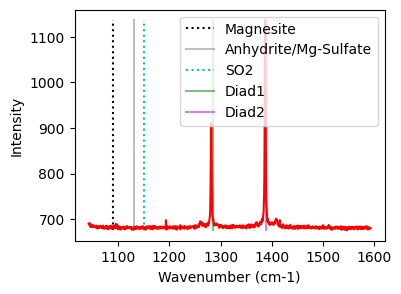

In [51]:
plot1=pf.plot_diad(path=spectra_path, filename=Diad_Files[i], filetype=spectra_filetype)

## Now lets inspect the diads and get their approximate positions
- As with generic peak, you can exclude 2 segments (e.g. around cosmic rays)
- You then specify how many peaks you want to fit on each diad. 1 means just the strong peak, 2 hotbands, and 3 for Diad2 would also fit the C13 peak if present. 
- The identify_diad_peaks then uses scipy findpeaks to identify the positions of the 2 diads, and any other peaks the user asks for. These are saved, and fed into the later functions for peak fitting. 

## Choose a model for fitting all peaks
- Option of Voigt or PseudoVoigt. We recomend PsuedoVoigt

In [52]:
model_name='PseudoVoigtModel'

## Fit Diad 1
- Tweak the parameters in the config files for each group. E.g. how many peaks (fit_peaks), the background positions, the sigma of the diad, and whether or not you want a gaussian background

In [53]:
diad_id_config=pf.diad_id_config(height=50, exclude_range1=[1308, 1309])
diad_id_config

# FG04 Standards
if batch=='Std':
    diad1_fit_config_init=pf.diad1_fit_config(
    model_name=model_name, fit_peaks=2,
    N_poly_bck_diad1=2, lower_bck_diad1=(1180, 1240),
    upper_bck_diad1=(1315, 1350),
    diad_sigma=0.6,
    x_range_residual=10, x_range_baseline=30, 
     y_range_baseline=100, 
    HB_prom=GroupN_df['HB1_abs_prom'].iloc[i], 
    diad_prom=GroupN_df['Diad1_abs_prom'].iloc[i])
    diad1_fit_config_init


if batch=='Weak':
    diad1_fit_config_init=pf.diad1_fit_config(
    model_name=model_name, fit_peaks=2,
    N_poly_bck_diad1=1, lower_bck_diad1=(1180, 1250),
    upper_bck_diad1=(1300, 1350),
    diad_sigma=0.6,
    x_range_residual=10, x_range_baseline=30, 
     y_range_baseline=100, 
    HB_prom=GroupN_df['HB1_abs_prom'].iloc[i], 
    diad_prom=GroupN_df['Diad1_abs_prom'].iloc[i])
    diad1_fit_config_init

if batch=='Medium':
    diad1_fit_config_init=pf.diad1_fit_config(
    model_name=model_name, fit_peaks=2,
    N_poly_bck_diad1=2, lower_bck_diad1=(1180, 1240),
    upper_bck_diad1=(1315, 1350),
    diad_sigma=0.6,
    x_range_residual=10, x_range_baseline=30, 
     y_range_baseline=100, 
    HB_prom=GroupN_df['HB1_abs_prom'].iloc[i], 
    diad_prom=GroupN_df['Diad1_abs_prom'].iloc[i])
    diad1_fit_config_init

if batch=='Strong':
    diad1_fit_config_init=pf.diad1_fit_config(
    fit_gauss=True, gauss_amp= 2*GroupN_df['HB1_abs_prom'].iloc[i],
    model_name=model_name, fit_peaks=2,
    N_poly_bck_diad1=1, lower_bck_diad1=(1180, 1220),
    upper_bck_diad1=(1330, 1350),
    diad_sigma=0.6,
    x_range_residual=10, x_range_baseline=30, 
     y_range_baseline=1000, 
    HB_prom=GroupN_df['HB1_abs_prom'].iloc[i], 
    diad_prom=GroupN_df['Diad1_abs_prom'].iloc[i])
diad1_fit_config_init

diad1_fit_config(model_name='PseudoVoigtModel', fit_peaks=2, N_poly_bck_diad1=2, lower_bck_diad1=(1180, 1240), upper_bck_diad1=(1315, 1350), fit_gauss=False, gauss_amp=1000, diad_sigma=0.6, diad_sigma_min_allowance=0.2, diad_sigma_max_allowance=5, diad_prom=236.97765959894366, HB_prom=nan, x_range_baseline=30, y_range_baseline=100, dpi=200, x_range_residual=10, return_other_params=False)

### See what these fit parameters look like for diad1

/Users/cljd/Documents/Python_dev/DiadFit/src/DiadFit/diads.py:2552: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df_out=df_out.fillna(0)


Diad1_Combofit_Cent  Diad1_Voigt_Cent  Diad1_cent_err  Diad1_Voigt_Area  \
0          1281.592407       1281.592407        0.009239        694.477796   

   Diad1_Voigt_Sigma  Diad1_Voigt_Gamma  Diad1_Combofit_Height  \
0           0.955891                  0             240.596297   

   Diad1_Residual  Diad1_Prop_Lor  Diad1_fwhm        Diad1_refit  \
0        2.690709        0.915125    1.911781  Flagged Warnings:   

   Diad1_Asym50  Diad1_Asym70  Diad1_Yuan2017_sym_factor  \
0      1.059675      1.010638                   0.114085   

   Diad1_Remigi2021_BSF   Diad1_PDF_Model  
0              0.007946  PseudoVoigtModel

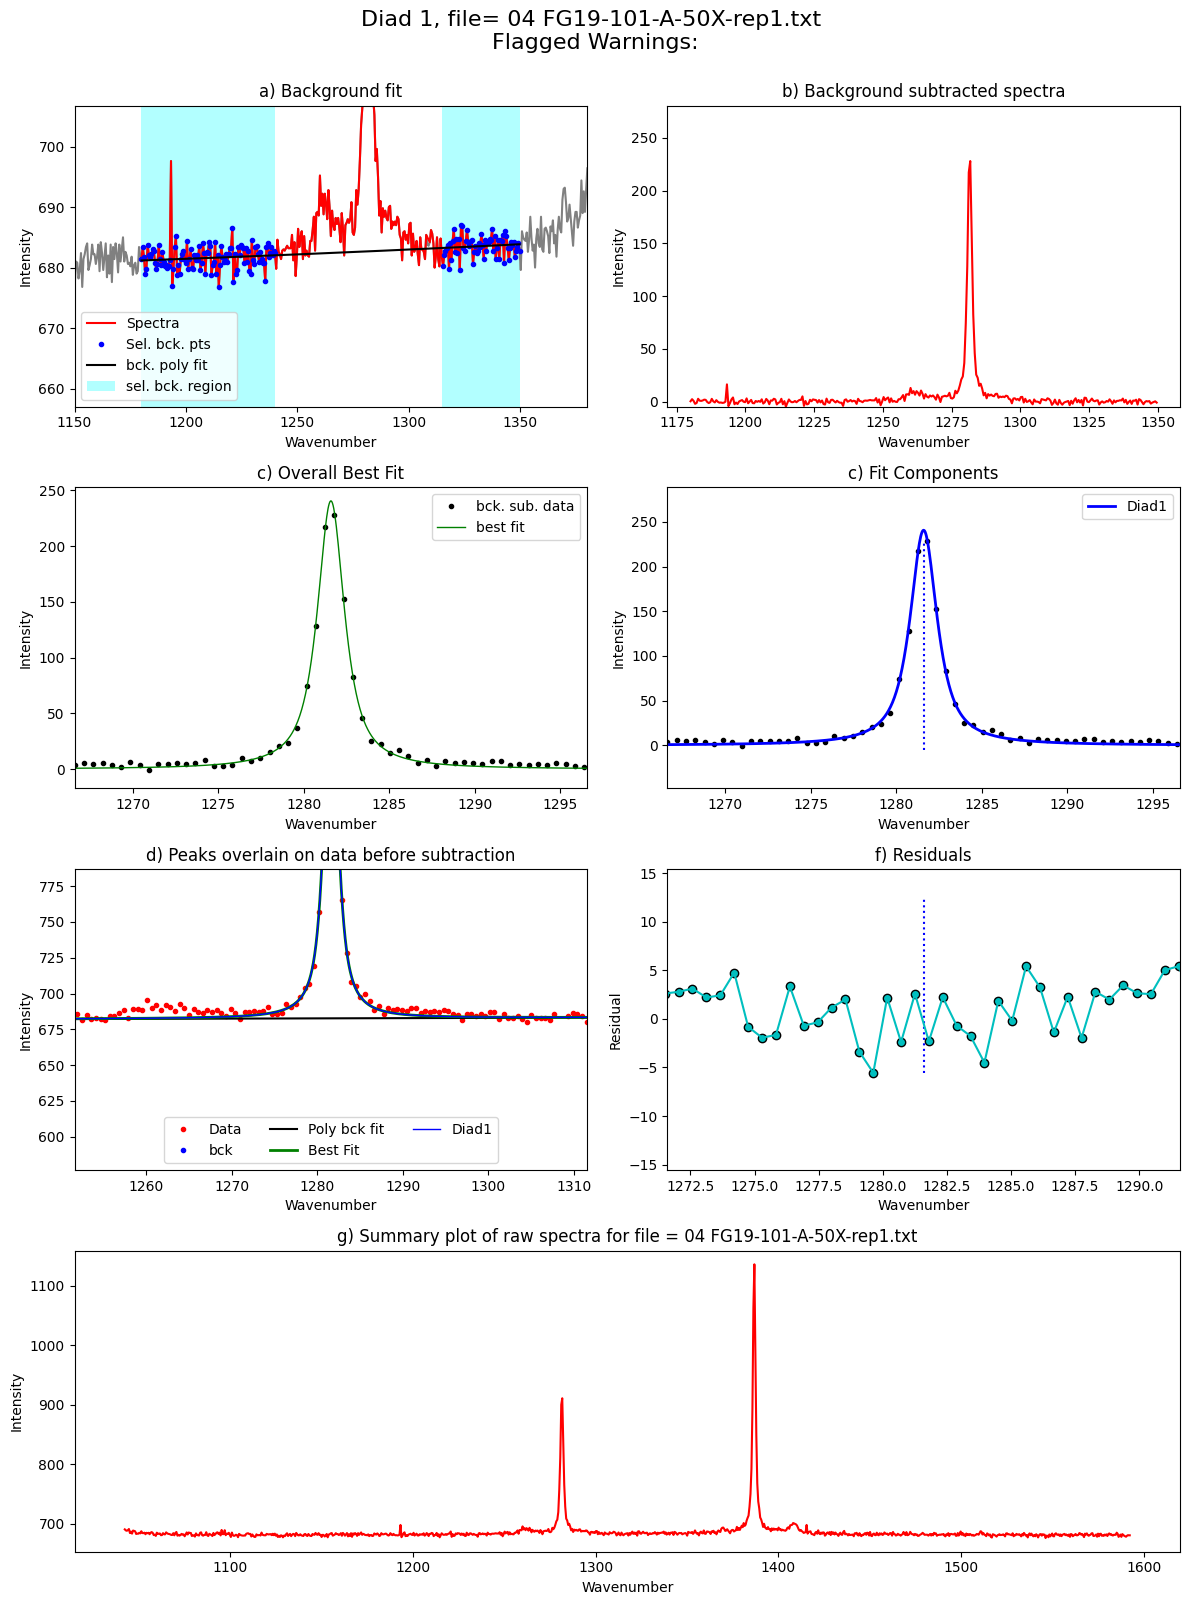

In [54]:
Diad1_fit=pf.fit_diad_1_w_bck(config1=diad1_fit_config_init,
config2=diad_id_config,
path=spectra_path, filename=Diad_Files.iloc[0],
filetype=spectra_filetype, plot_figure=True, close_figure=False,
Diad_pos=GroupN_df['Diad1_pos'].iloc[i],
HB_pos=GroupN_df['HB1_pos'].iloc[i])
Diad1_fit

### Update the sigma
- The sigma parameter varies quite a lot based on the splitting. Best to update your first guess with what you found for the example file above

In [55]:
diad1_fit_config2=diad1_fit_config_init

## Fit diad2

In [56]:
if batch=='Std':
    diad2_fit_config_init=pf.diad2_fit_config(model_name=model_name,
    fit_peaks=3, fit_gauss=True, gauss_amp= 2*GroupN_df['HB2_abs_prom'].iloc[i],
    lower_bck_diad2=(1310, 1350), diad_sigma=1,  N_poly_bck_diad2=2,                                       
    x_range_residual=30, y_range_baseline=100,  
    x_range_baseline=30,
    HB_prom=GroupN_df['HB2_abs_prom'].iloc[i], 
    diad_prom=GroupN_df['Diad2_abs_prom'].iloc[i],
    C13_prom=GroupN_df['C13_abs_prom'].iloc[i])
    diad2_fit_config_init


if batch=='Weak':
    diad2_fit_config_init=pf.diad2_fit_config(model_name=model_name,
    fit_peaks=2, upper_bck_diad2=(1430, 1480),
    lower_bck_diad2=(1310, 1360), diad_sigma=0.4,  N_poly_bck_diad2=2,                                       
    x_range_residual=30, y_range_baseline=100,  
    x_range_baseline=30,
    HB_prom=GroupN_df['HB2_abs_prom'].iloc[i], 
    diad_prom=GroupN_df['Diad2_abs_prom'].iloc[i])
    diad2_fit_config_init

if batch=='Medium':
    diad2_fit_config_init=pf.diad2_fit_config(model_name=model_name,
    fit_peaks=3, fit_gauss=False, gauss_amp= 2*GroupN_df['HB2_abs_prom'].iloc[i],
    lower_bck_diad2=(1310, 1350), diad_sigma=1,  N_poly_bck_diad2=2,                                       
    x_range_residual=30, y_range_baseline=100,  
    x_range_baseline=30,
    HB_prom=GroupN_df['HB2_abs_prom'].iloc[i], 
    diad_prom=GroupN_df['Diad2_abs_prom'].iloc[i],
    C13_prom=GroupN_df['C13_abs_prom'].iloc[i])
    diad2_fit_config_init

if batch=='Strong':
    diad2_fit_config_init=pf.diad2_fit_config(model_name=model_name,
    fit_peaks=3, fit_gauss=True, gauss_amp= 2*GroupN_df['HB2_abs_prom'].iloc[i],
    lower_bck_diad2=(1310, 1340), diad_sigma=1,  N_poly_bck_diad2=2,                                       
    x_range_residual=30, y_range_baseline=1000,  
    x_range_baseline=30,
    HB_prom=GroupN_df['HB2_abs_prom'].iloc[i], 
    diad_prom=GroupN_df['Diad2_abs_prom'].iloc[i],
    C13_prom=GroupN_df['C13_abs_prom'].iloc[i])
    diad2_fit_config_init
diad2_fit_config_init

diad2_fit_config(model_name='PseudoVoigtModel', fit_peaks=3, N_poly_bck_diad2=2, lower_bck_diad2=(1310, 1350), upper_bck_diad2=(1440, 1470), fit_gauss=True, gauss_amp=nan, diad_sigma=1, diad_sigma_min_allowance=0.2, diad_sigma_max_allowance=5, diad_prom=456.6180709424377, HB_prom=nan, C13_prom=nan, x_range_baseline=30, y_range_baseline=100, plot_figure=True, dpi=200, x_range_residual=30, return_other_params=False)

### See what these fit parameters look like for diad2

/Users/cljd/Documents/Python_dev/DiadFit/src/DiadFit/diads.py:2552: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df_out=df_out.fillna(0)


Diad2_Combofit_Cent  Diad2_Voigt_Cent  Diad2_cent_err  Diad2_Voigt_Area  \
0          1386.823837       1386.823837        0.006428       1241.158029   

   Diad2_Voigt_Sigma  Diad2_Voigt_Gamma  Diad2_Combofit_Height  \
0           0.889958                  0             461.806502   

   Diad2_Residual  Diad2_Prop_Lor  Diad2_fwhm        Diad2_refit  \
0        3.464363        0.915309    1.779915  Flagged Warnings:   

   Diad2_Asym50  Diad2_Asym70  Diad2_Yuan2017_sym_factor  \
0      1.022642      1.017016                     0.0403   

   Diad2_Remigi2021_BSF   Diad2_PDF_Model  
0              0.003854  PseudoVoigtModel

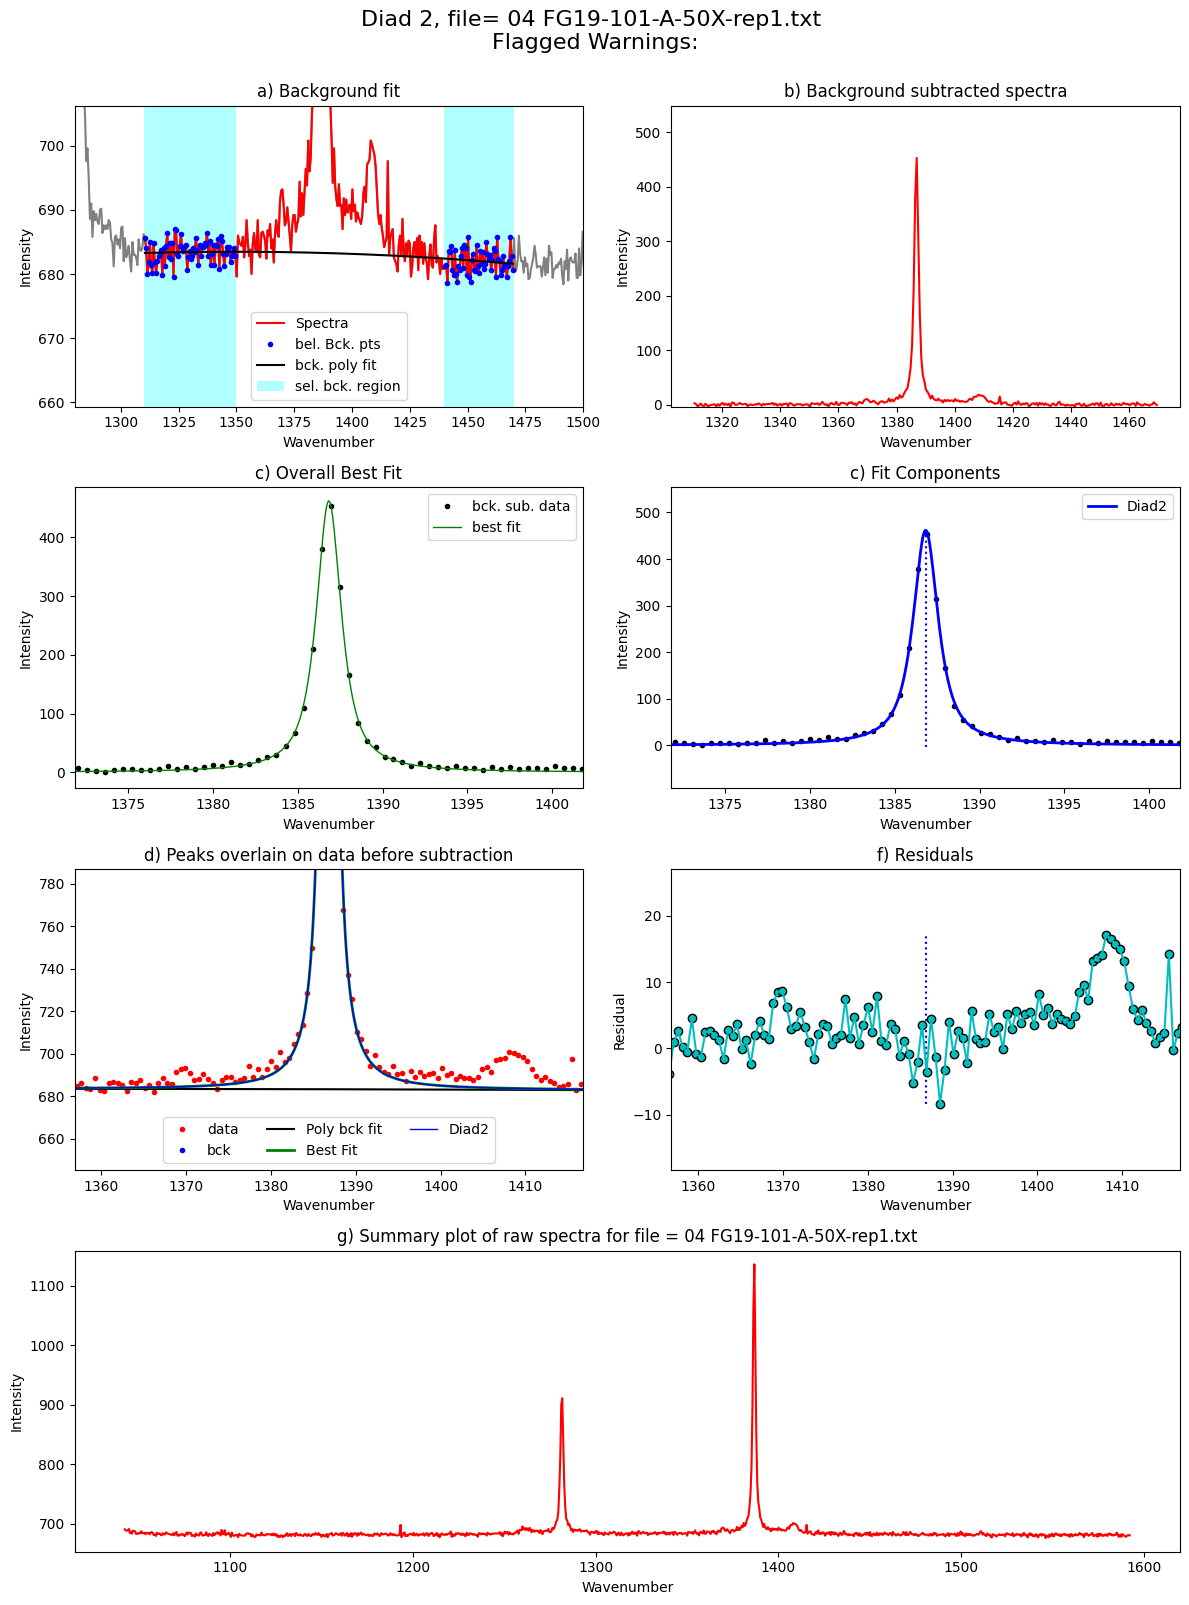

In [57]:
Diad2_fit=pf.fit_diad_2_w_bck(config1=diad2_fit_config_init,
    config2=diad_id_config,
path=spectra_path, filename=Diad_Files[i], filetype=spectra_filetype,
plot_figure=True, close_figure=False, 
Diad_pos=GroupN_df['Diad2_pos'].iloc[i],
HB_pos=GroupN_df['HB2_pos'].iloc[i], 
C13_pos=GroupN_df['C13_pos'].iloc[i])
Diad2_fit.to_clipboard(excel=True)
Diad2_fit

## Loop over all the files in the group
- This will loop over all the 

  0%|          | 0/7 [00:00<?, ?it/s]/Users/cljd/Documents/Python_dev/DiadFit/src/DiadFit/diads.py:2552: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df_out=df_out.fillna(0)


Processing file: 04 FG19-101-A-50X-rep1.txt


/Users/cljd/Documents/Python_dev/DiadFit/src/DiadFit/diads.py:2552: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df_out=df_out.fillna(0)
 14%|█▍        | 1/7 [00:01<00:08,  1.42s/it]/Users/cljd/Documents/Python_dev/DiadFit/src/DiadFit/diads.py:2552: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df_out=df_out.fillna(0)


Processing file: 05 FG19-101-A-50X-rep2.txt


/Users/cljd/Documents/Python_dev/DiadFit/src/DiadFit/diads.py:2552: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df_out=df_out.fillna(0)
 29%|██▊       | 2/7 [00:02<00:06,  1.32s/it]/Users/cljd/Documents/Python_dev/DiadFit/src/DiadFit/diads.py:2552: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df_out=df_out.fillna(0)


Processing file: 06 FG19-101-A-50X-rep3.txt


/Users/cljd/Documents/Python_dev/DiadFit/src/DiadFit/diads.py:2552: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df_out=df_out.fillna(0)
 43%|████▎     | 3/7 [00:03<00:05,  1.29s/it]/Users/cljd/Documents/Python_dev/DiadFit/src/DiadFit/diads.py:2552: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df_out=df_out.fillna(0)


Processing file: 07 FG19-101-A-50X-12mw.txt


/Users/cljd/Documents/Python_dev/DiadFit/src/DiadFit/diads.py:2552: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df_out=df_out.fillna(0)
 57%|█████▋    | 4/7 [00:05<00:03,  1.28s/it]/Users/cljd/Documents/Python_dev/DiadFit/src/DiadFit/diads.py:2552: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df_out=df_out.fillna(0)


Processing file: 44 FG19-101-A-50X-rep4.txt


/Users/cljd/Documents/Python_dev/DiadFit/src/DiadFit/diads.py:2552: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df_out=df_out.fillna(0)
 71%|███████▏  | 5/7 [00:06<00:02,  1.38s/it]/Users/cljd/Documents/Python_dev/DiadFit/src/DiadFit/diads.py:2552: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df_out=df_out.fillna(0)


Processing file: 45 FG19-101-A-50X-rep5_CRR_DiadFit.txt


/Users/cljd/Documents/Python_dev/DiadFit/src/DiadFit/diads.py:2552: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df_out=df_out.fillna(0)
 86%|████████▌ | 6/7 [00:08<00:01,  1.51s/it]/Users/cljd/Documents/Python_dev/DiadFit/src/DiadFit/diads.py:2552: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df_out=df_out.fillna(0)


Processing file: 46 FG19-101-A-50X-rep6_CRR_DiadFit.txt


/Users/cljd/Documents/Python_dev/DiadFit/src/DiadFit/diads.py:2552: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df_out=df_out.fillna(0)
100%|██████████| 7/7 [00:09<00:00,  1.42s/it]


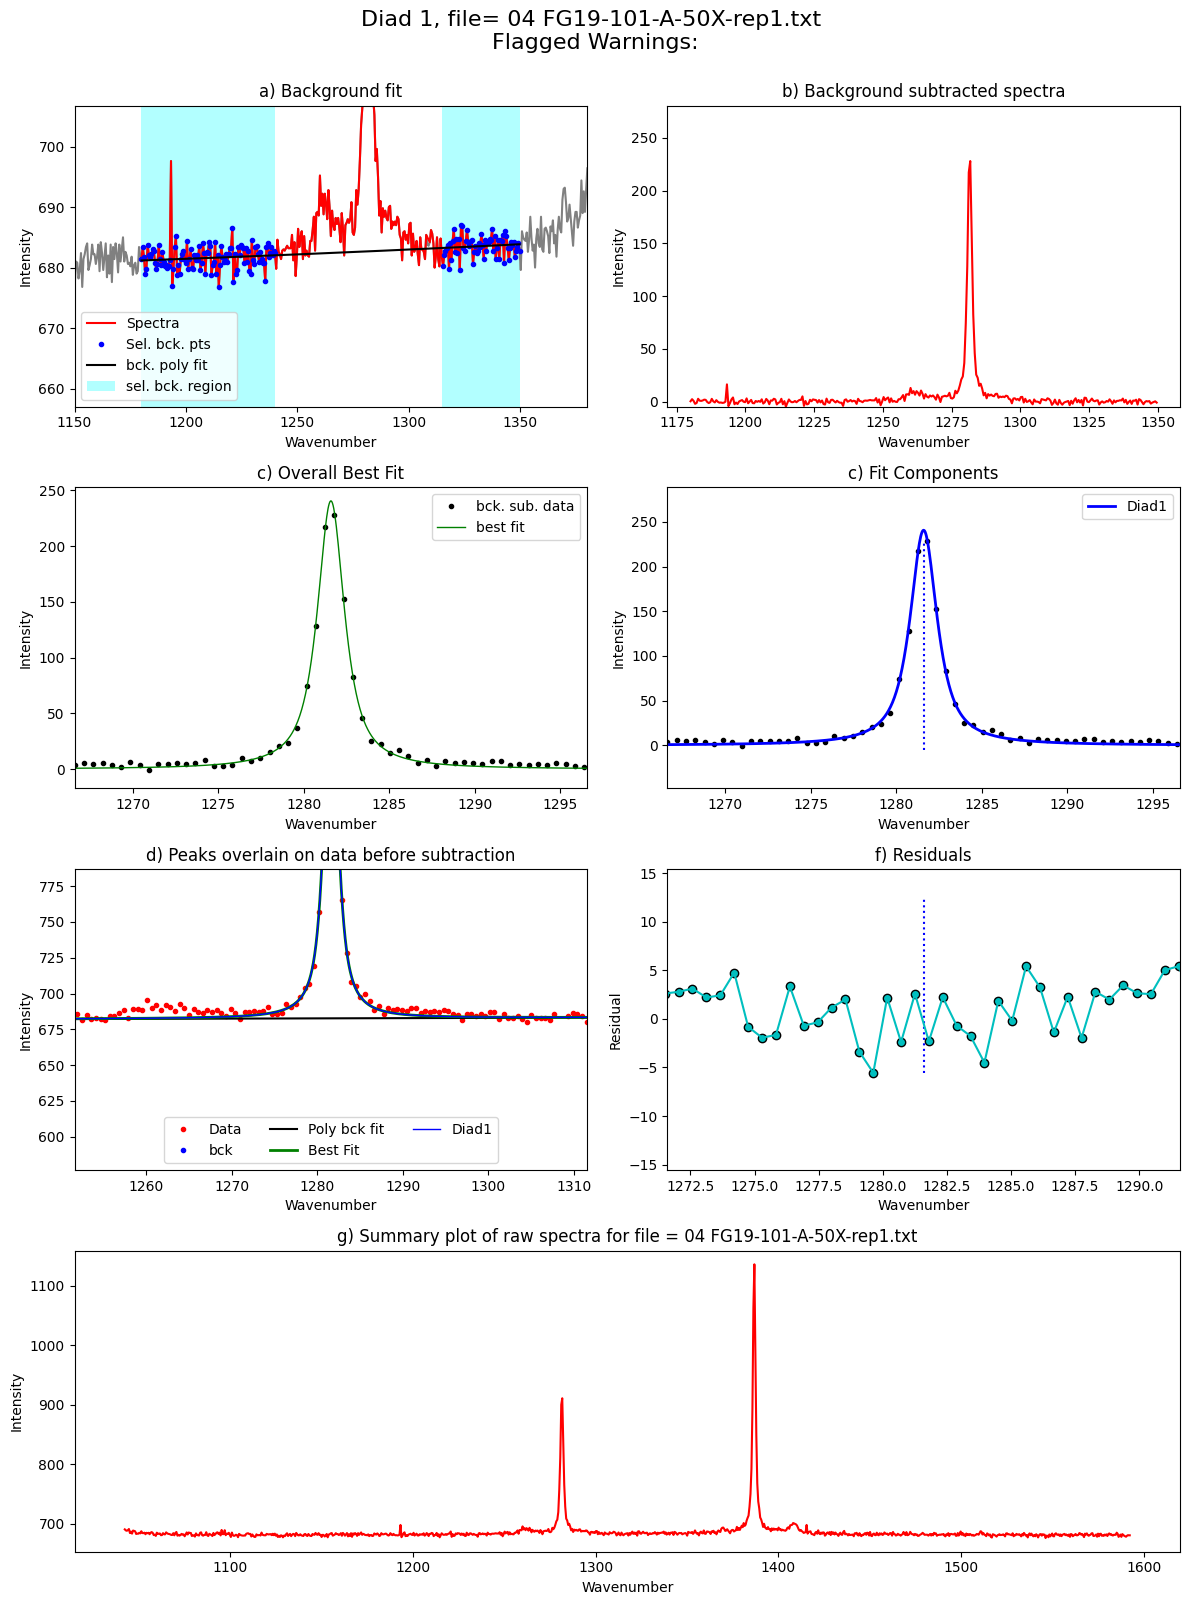

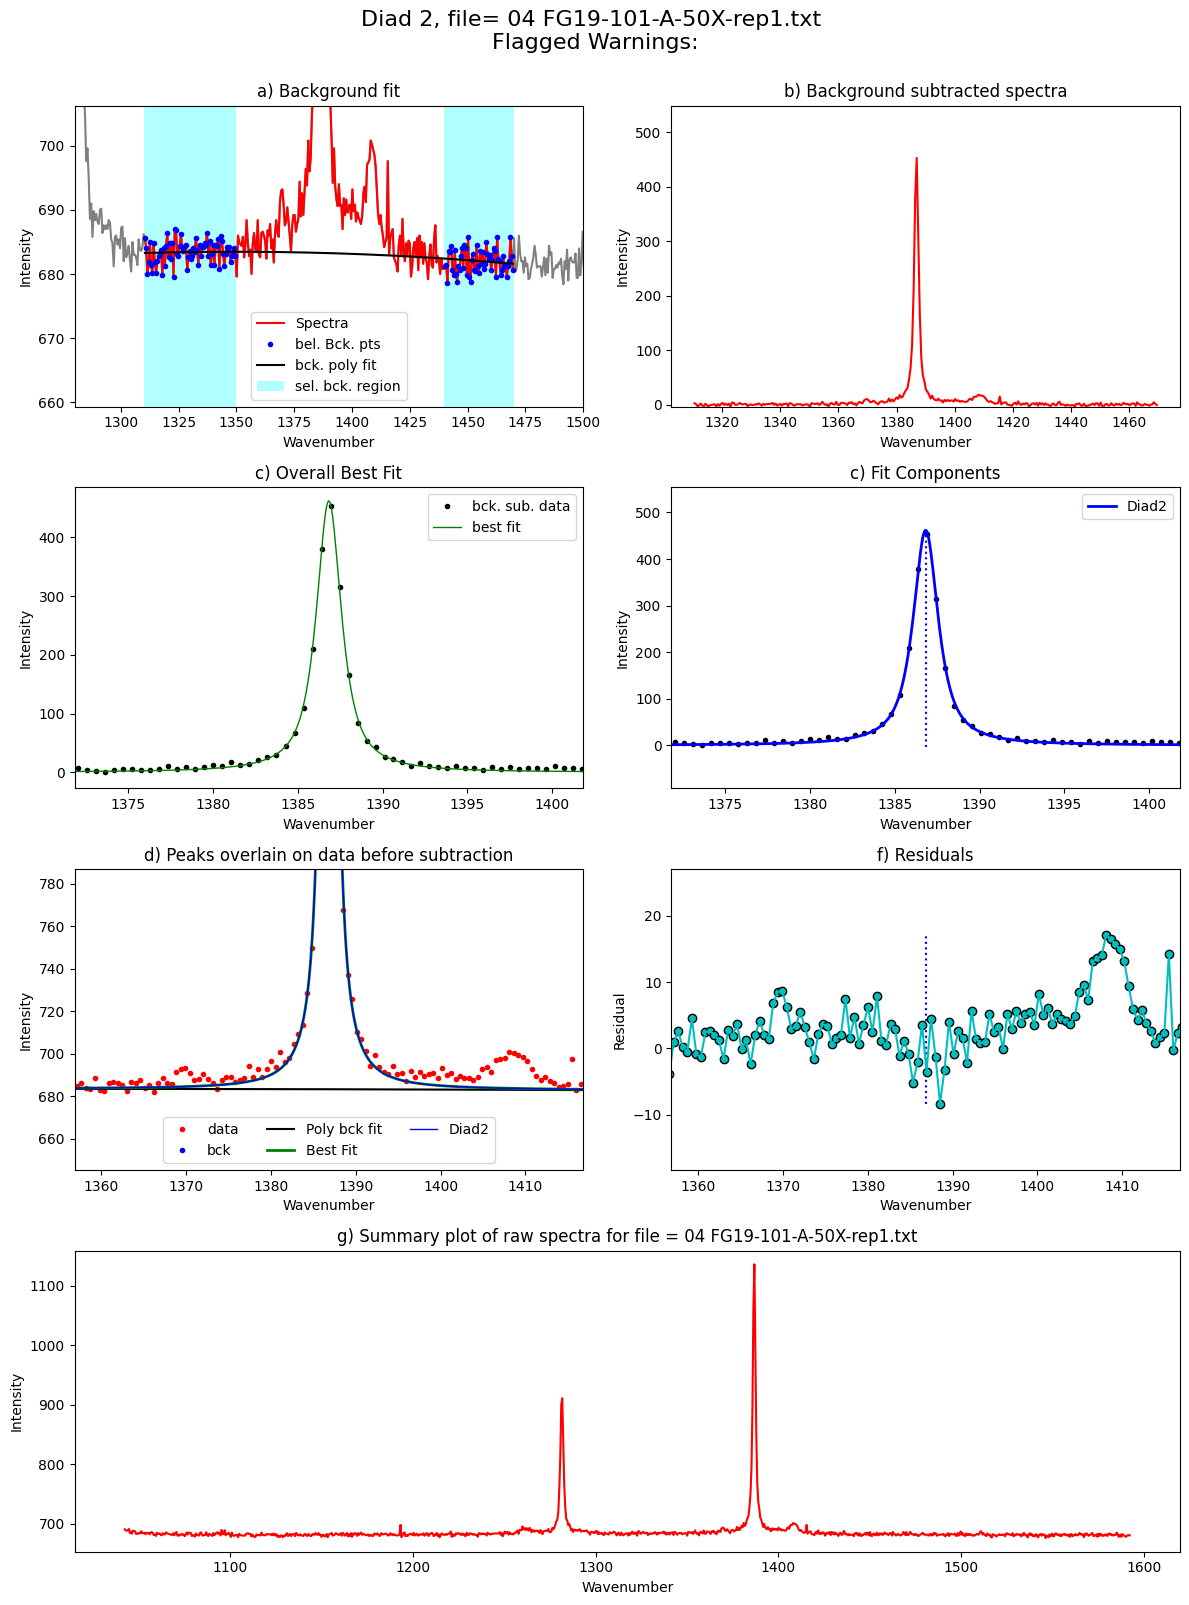

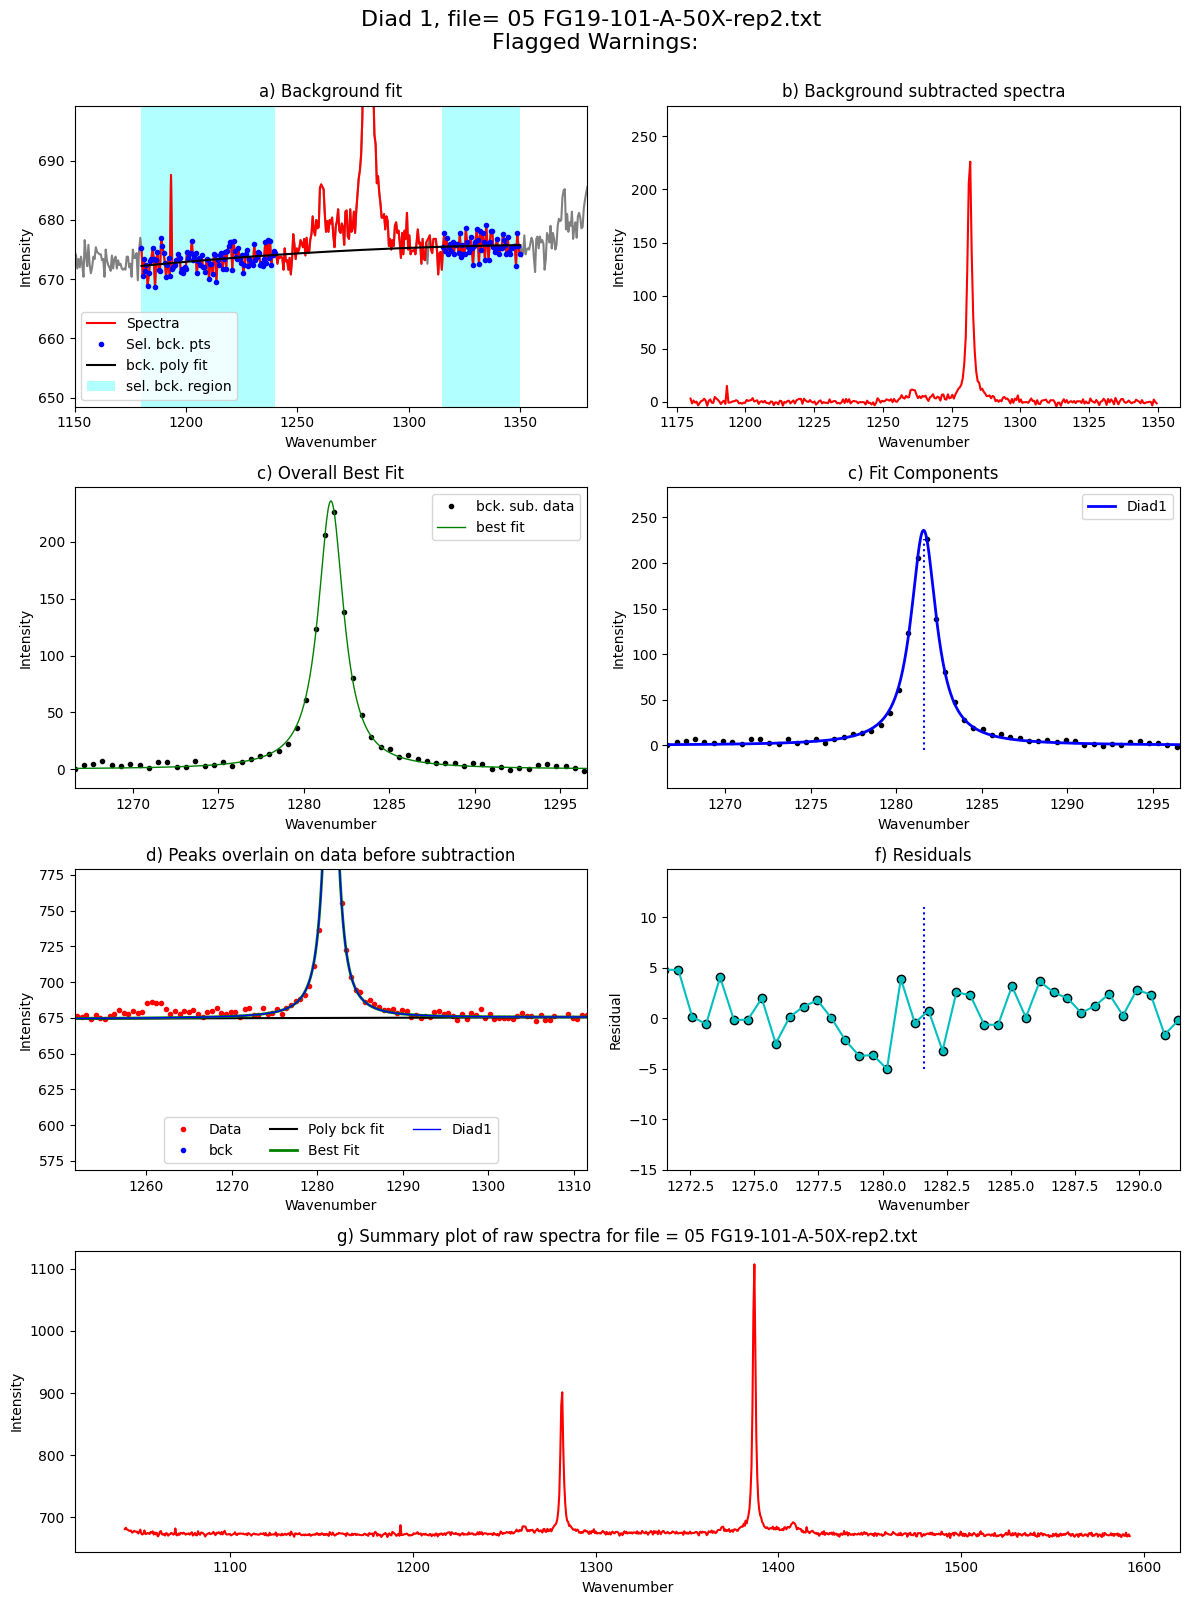

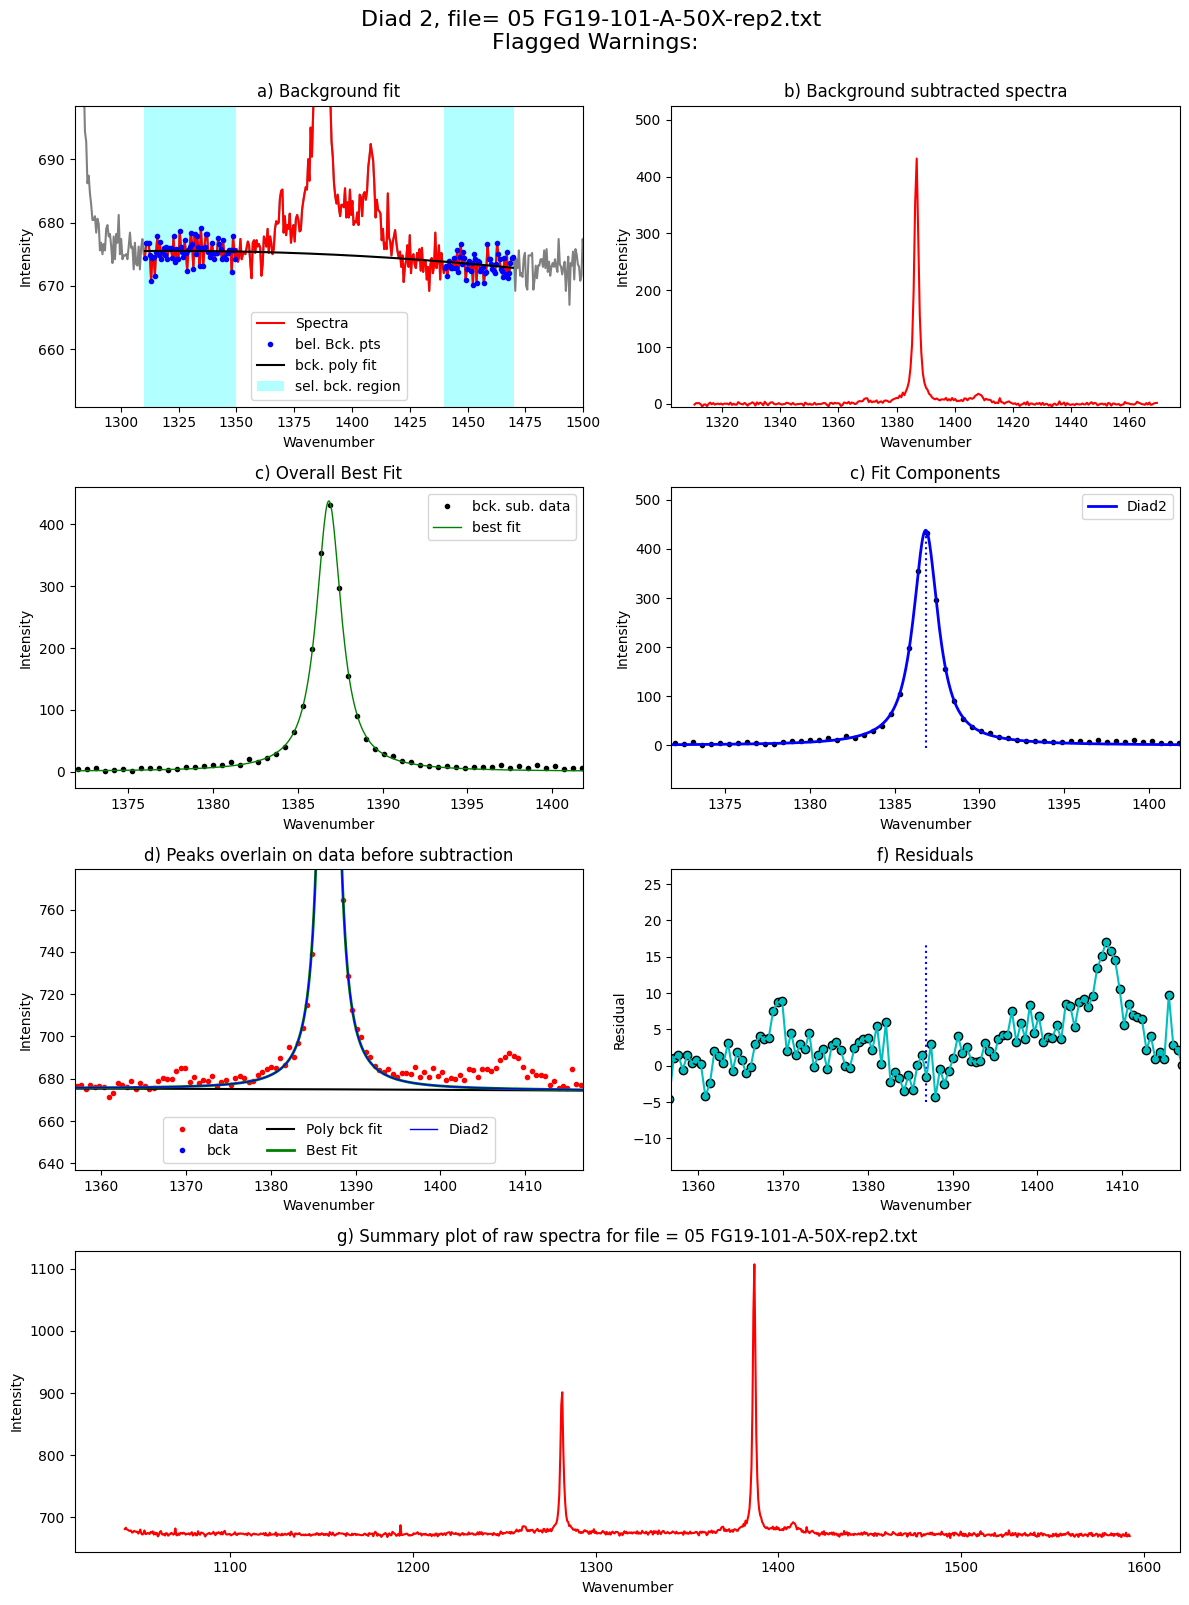

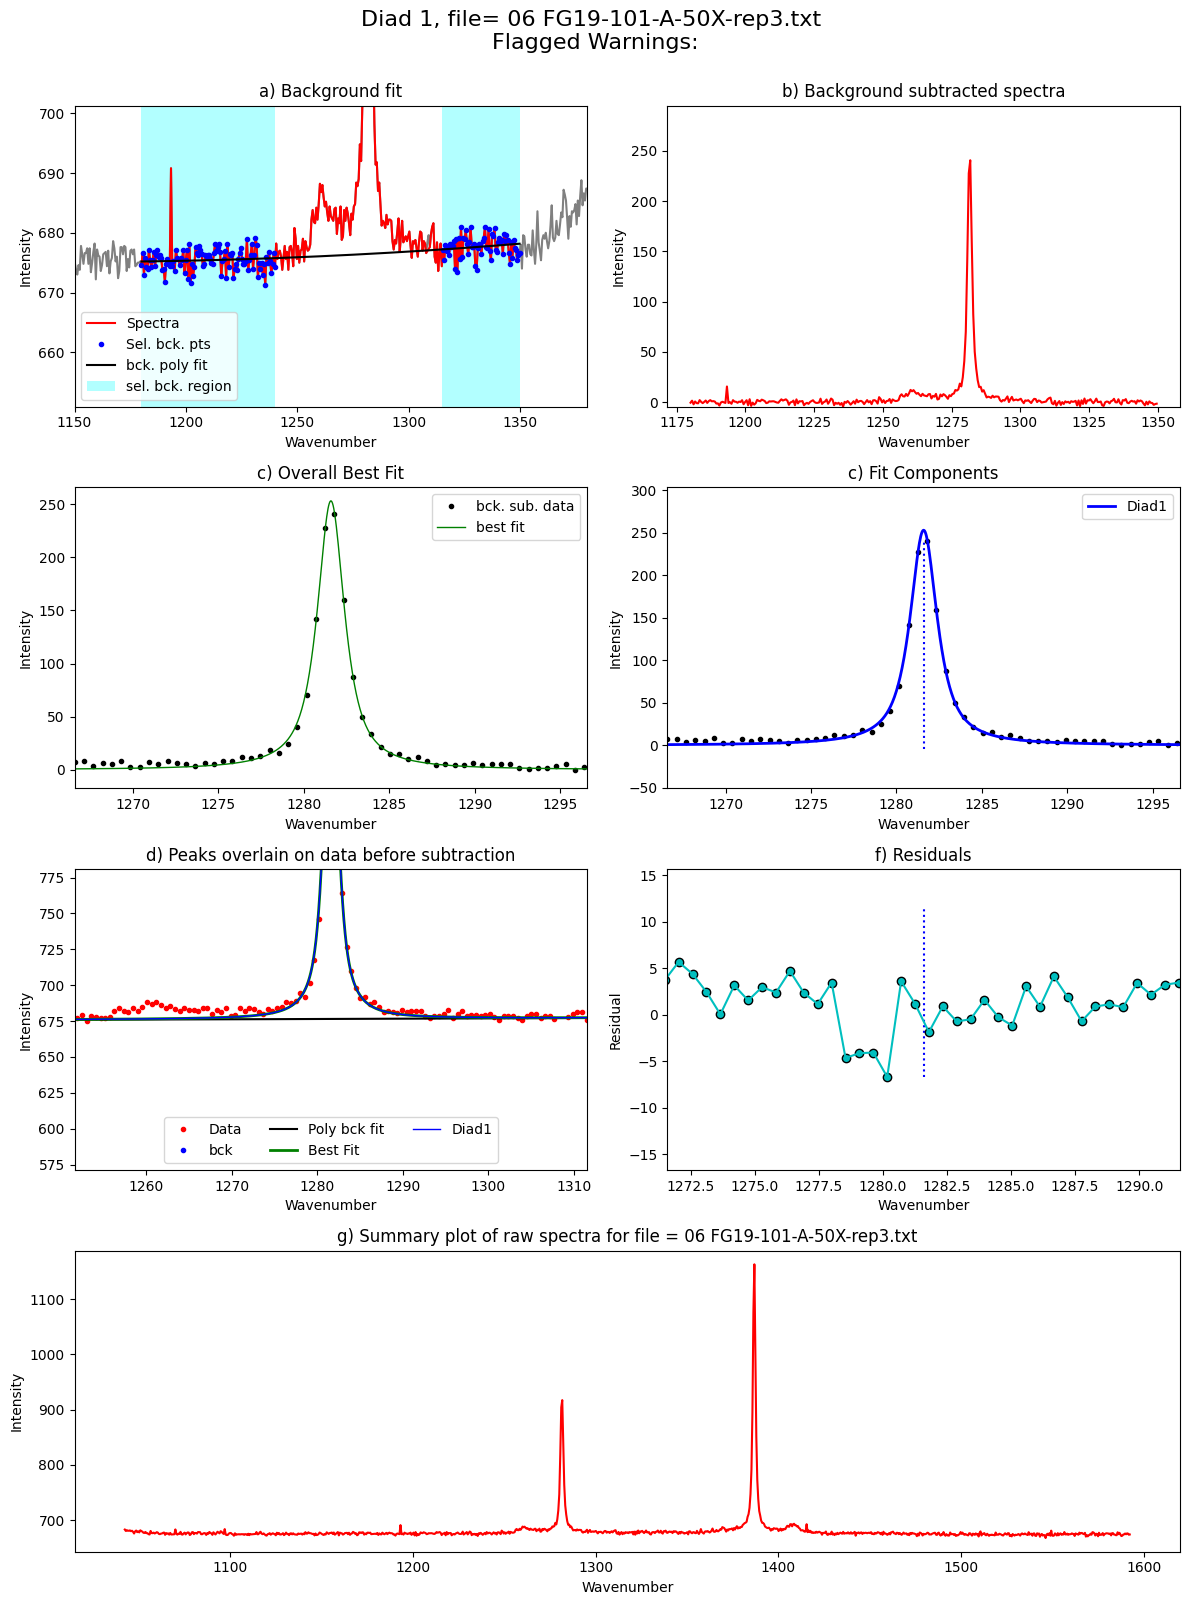

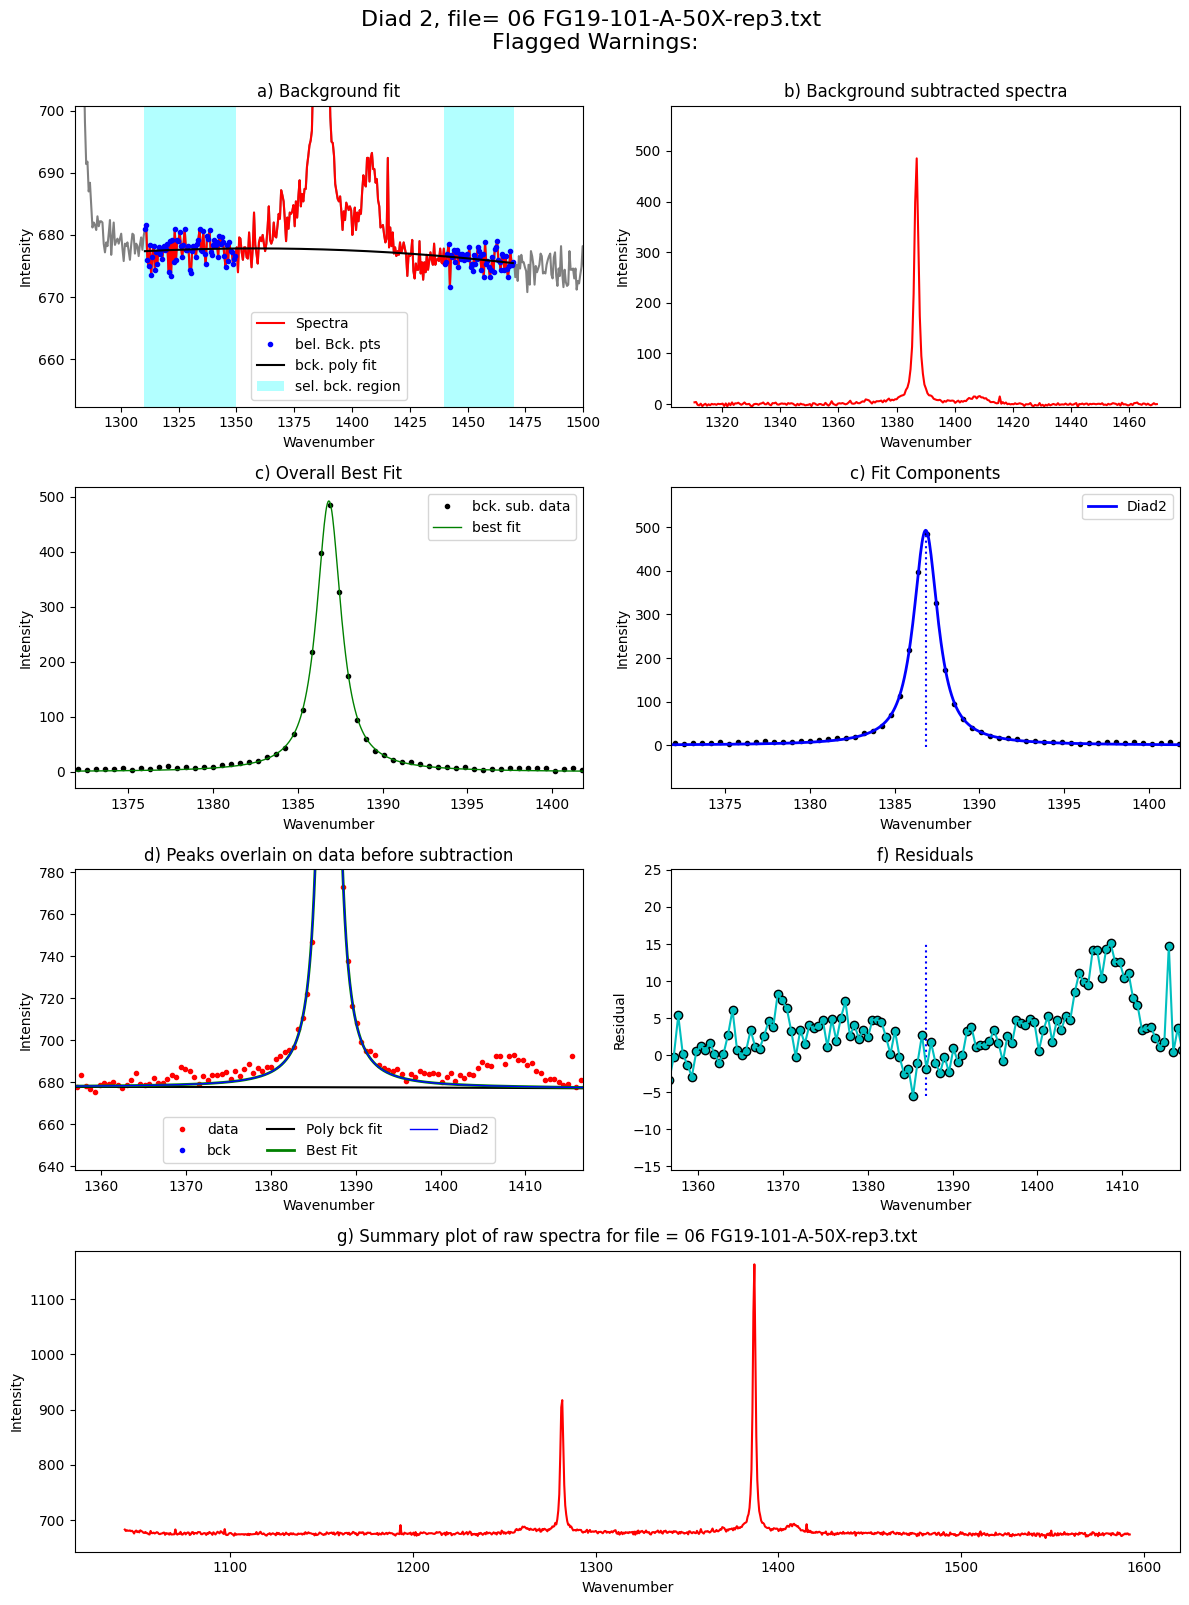

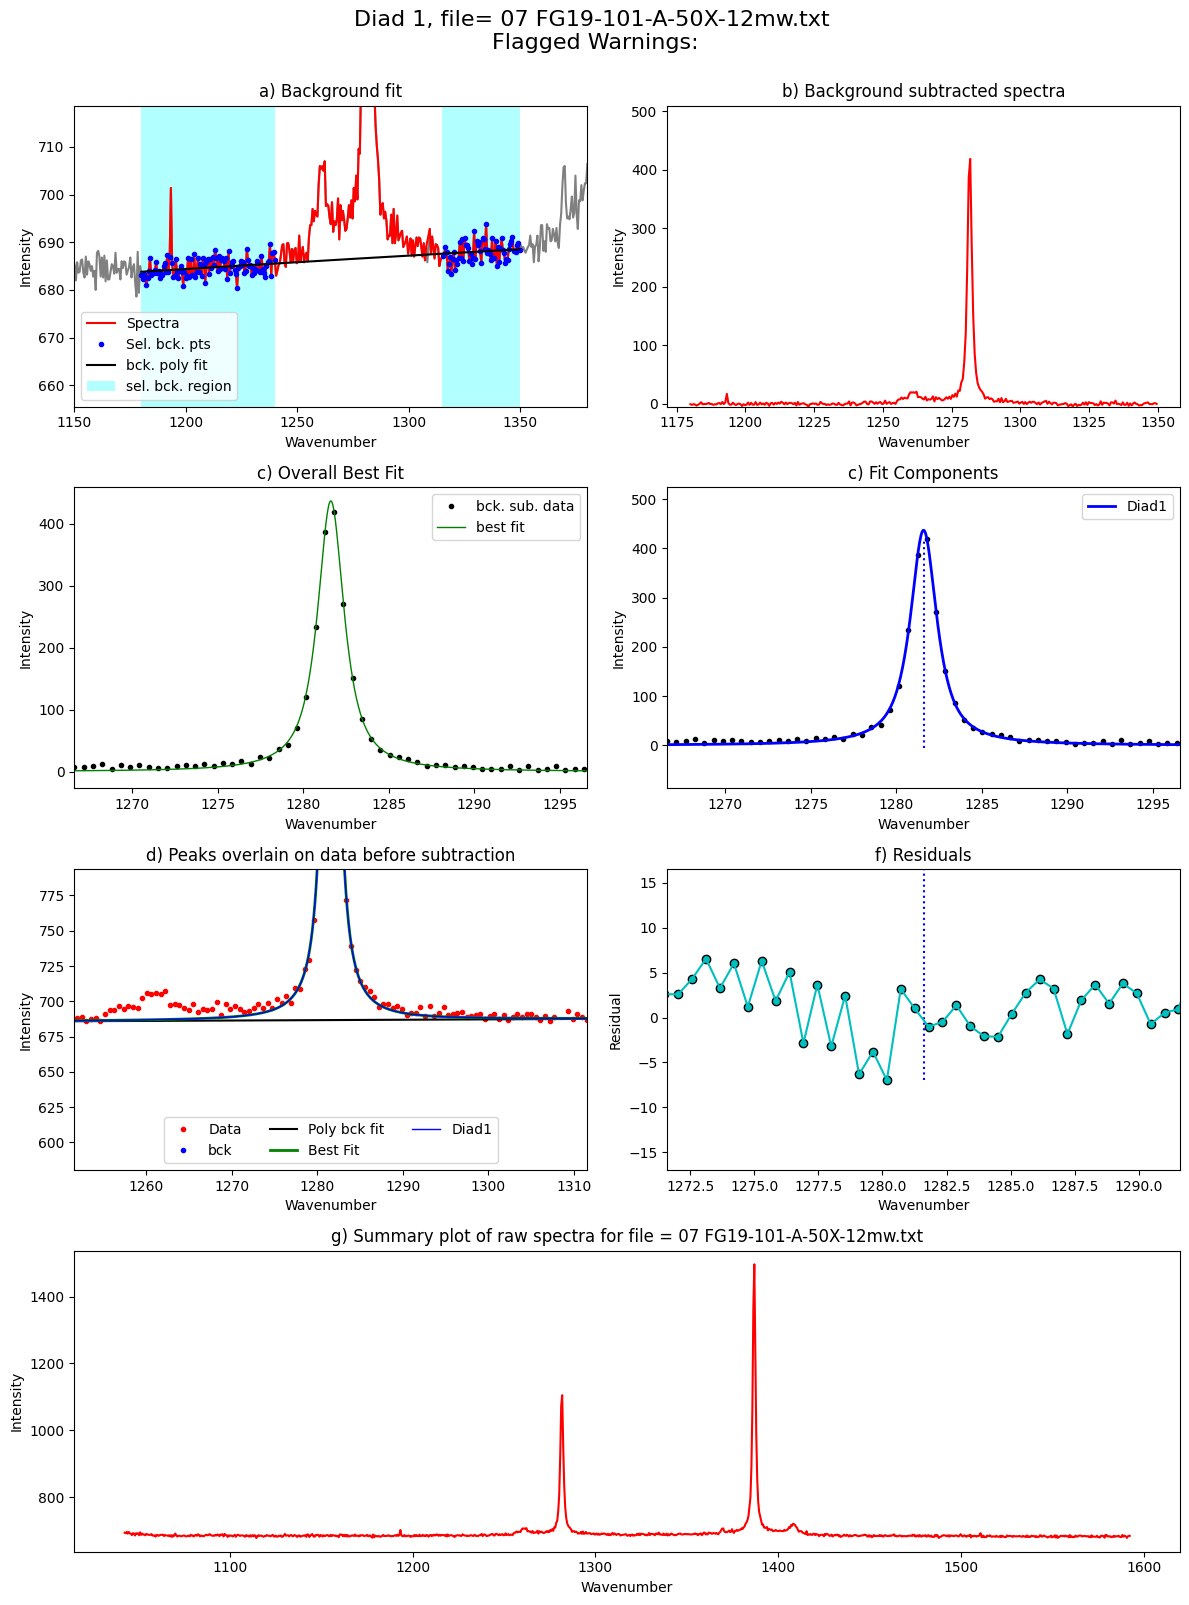

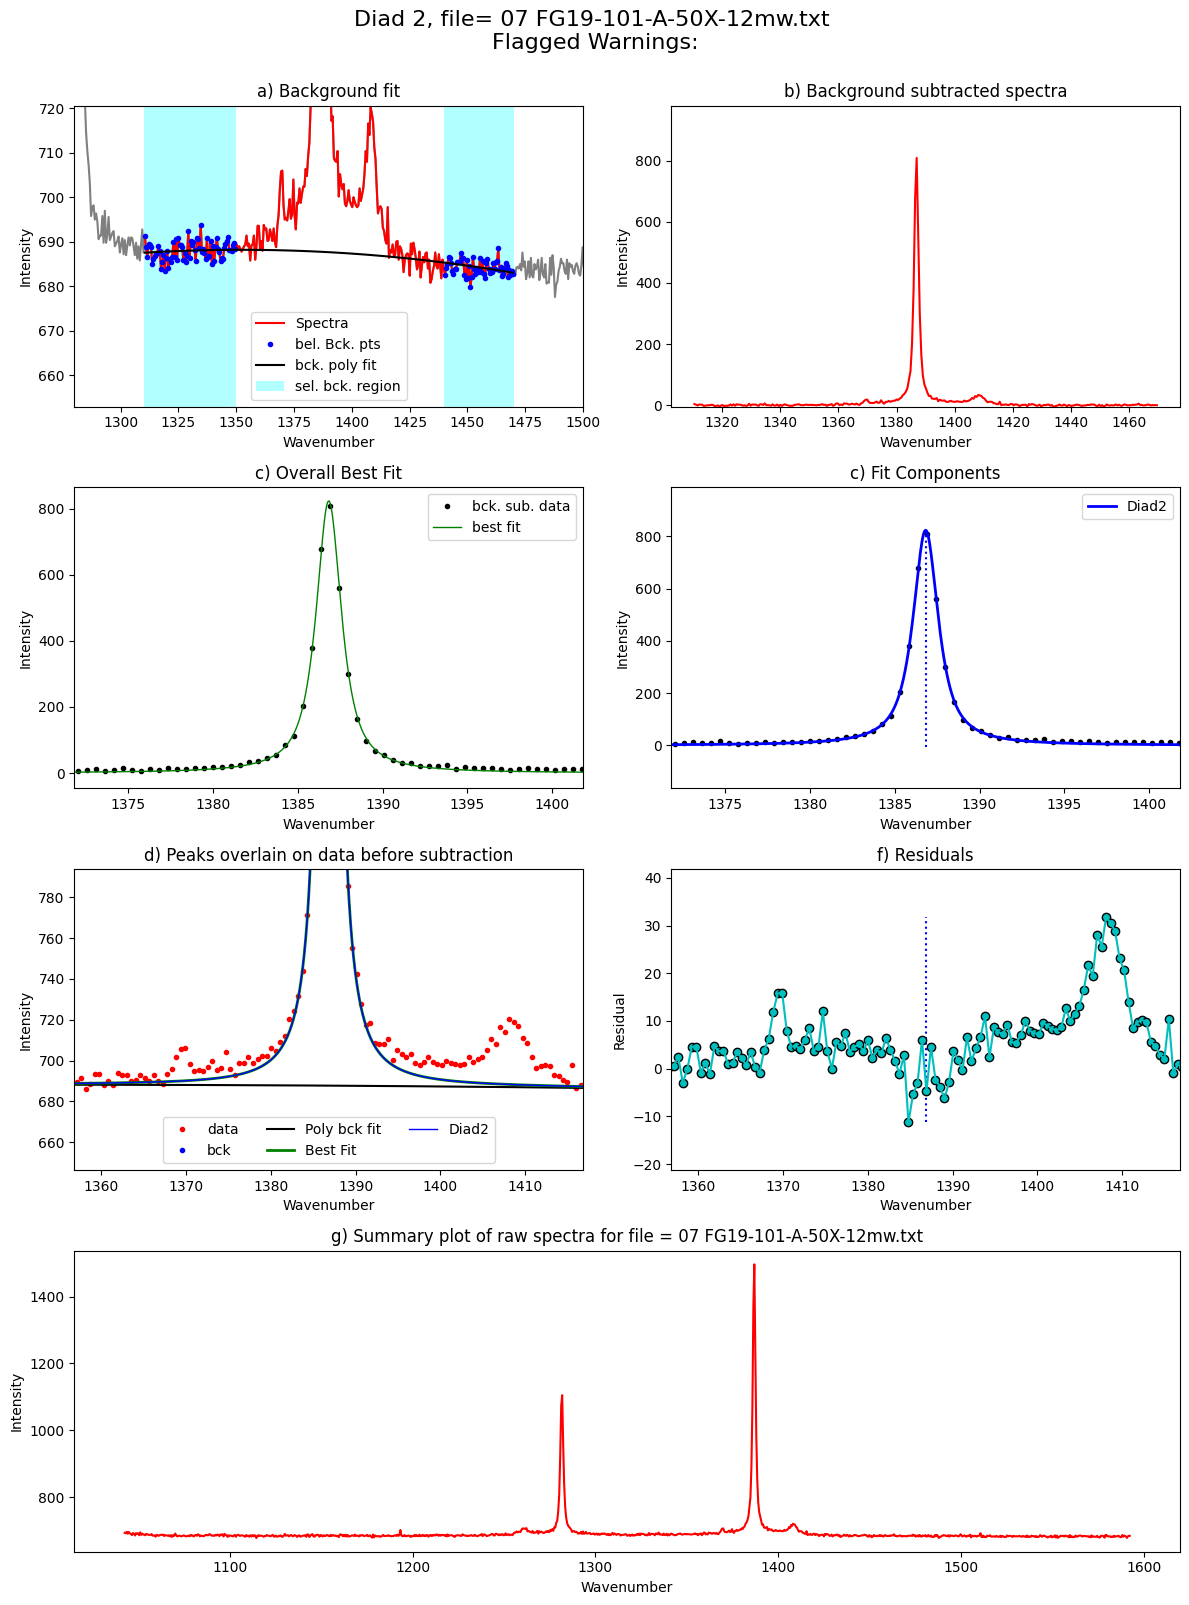

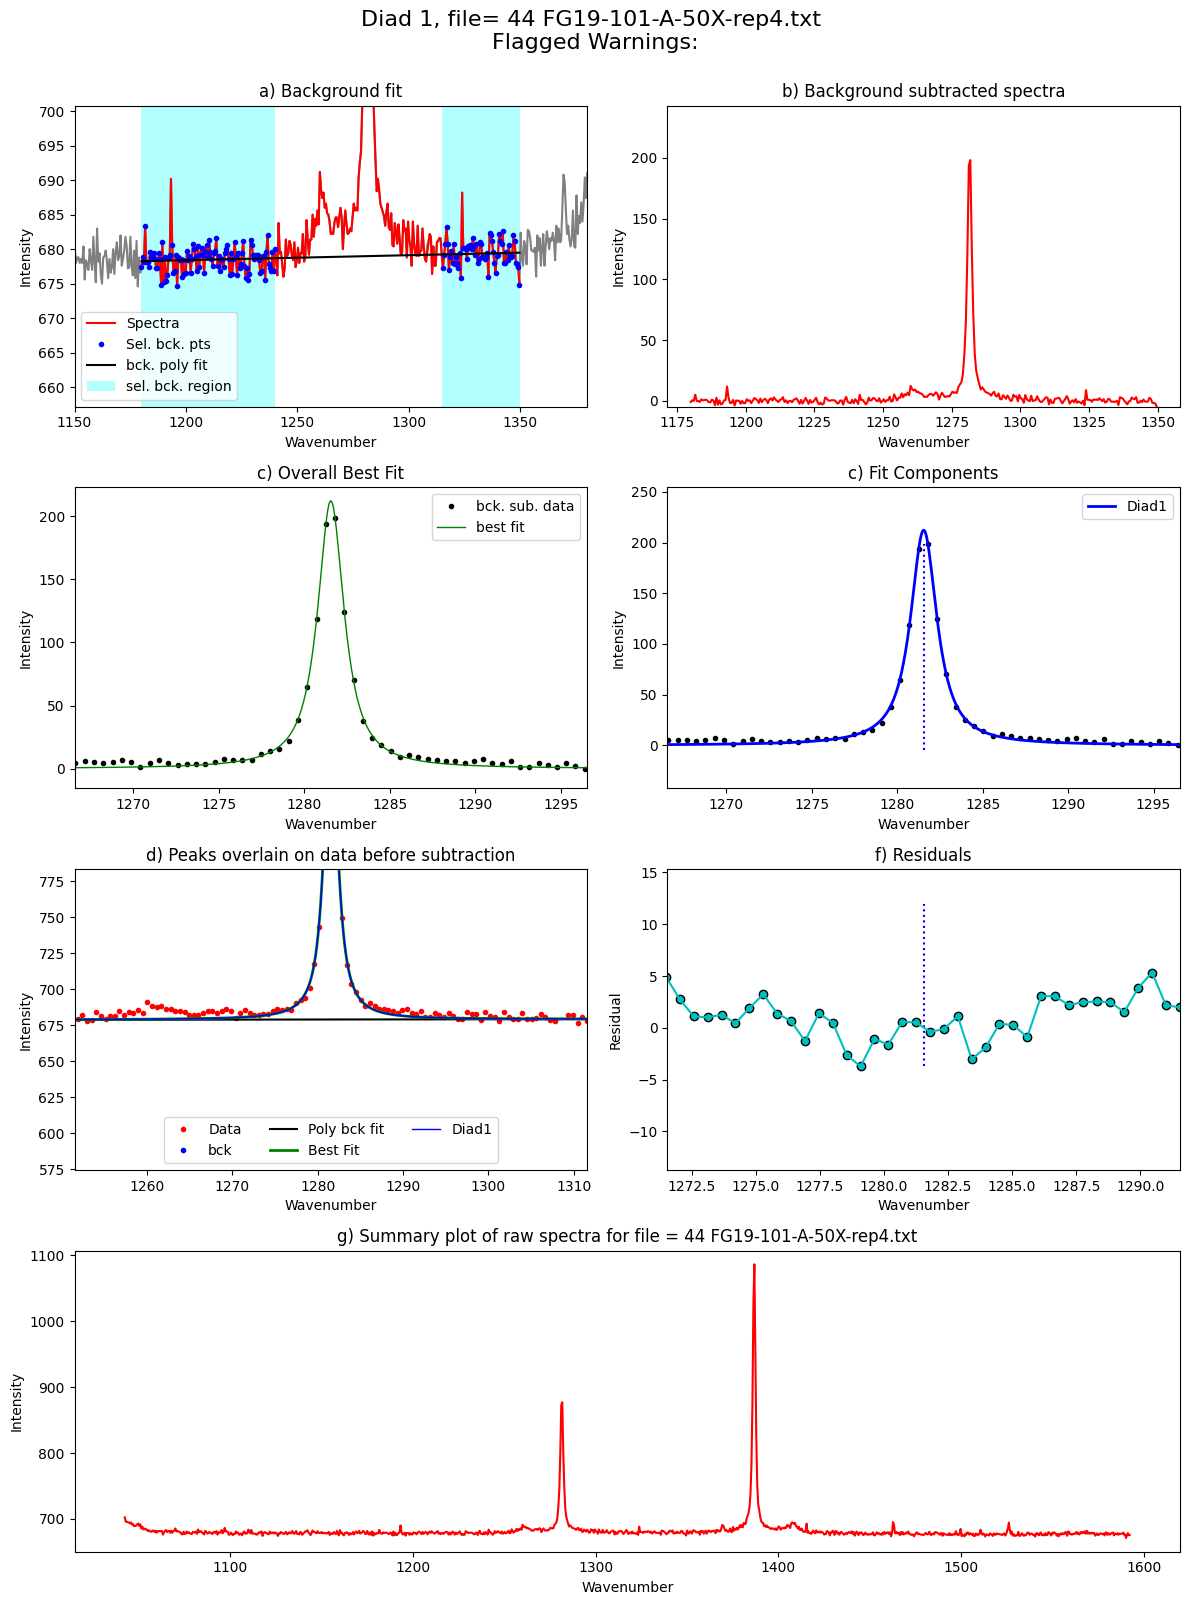

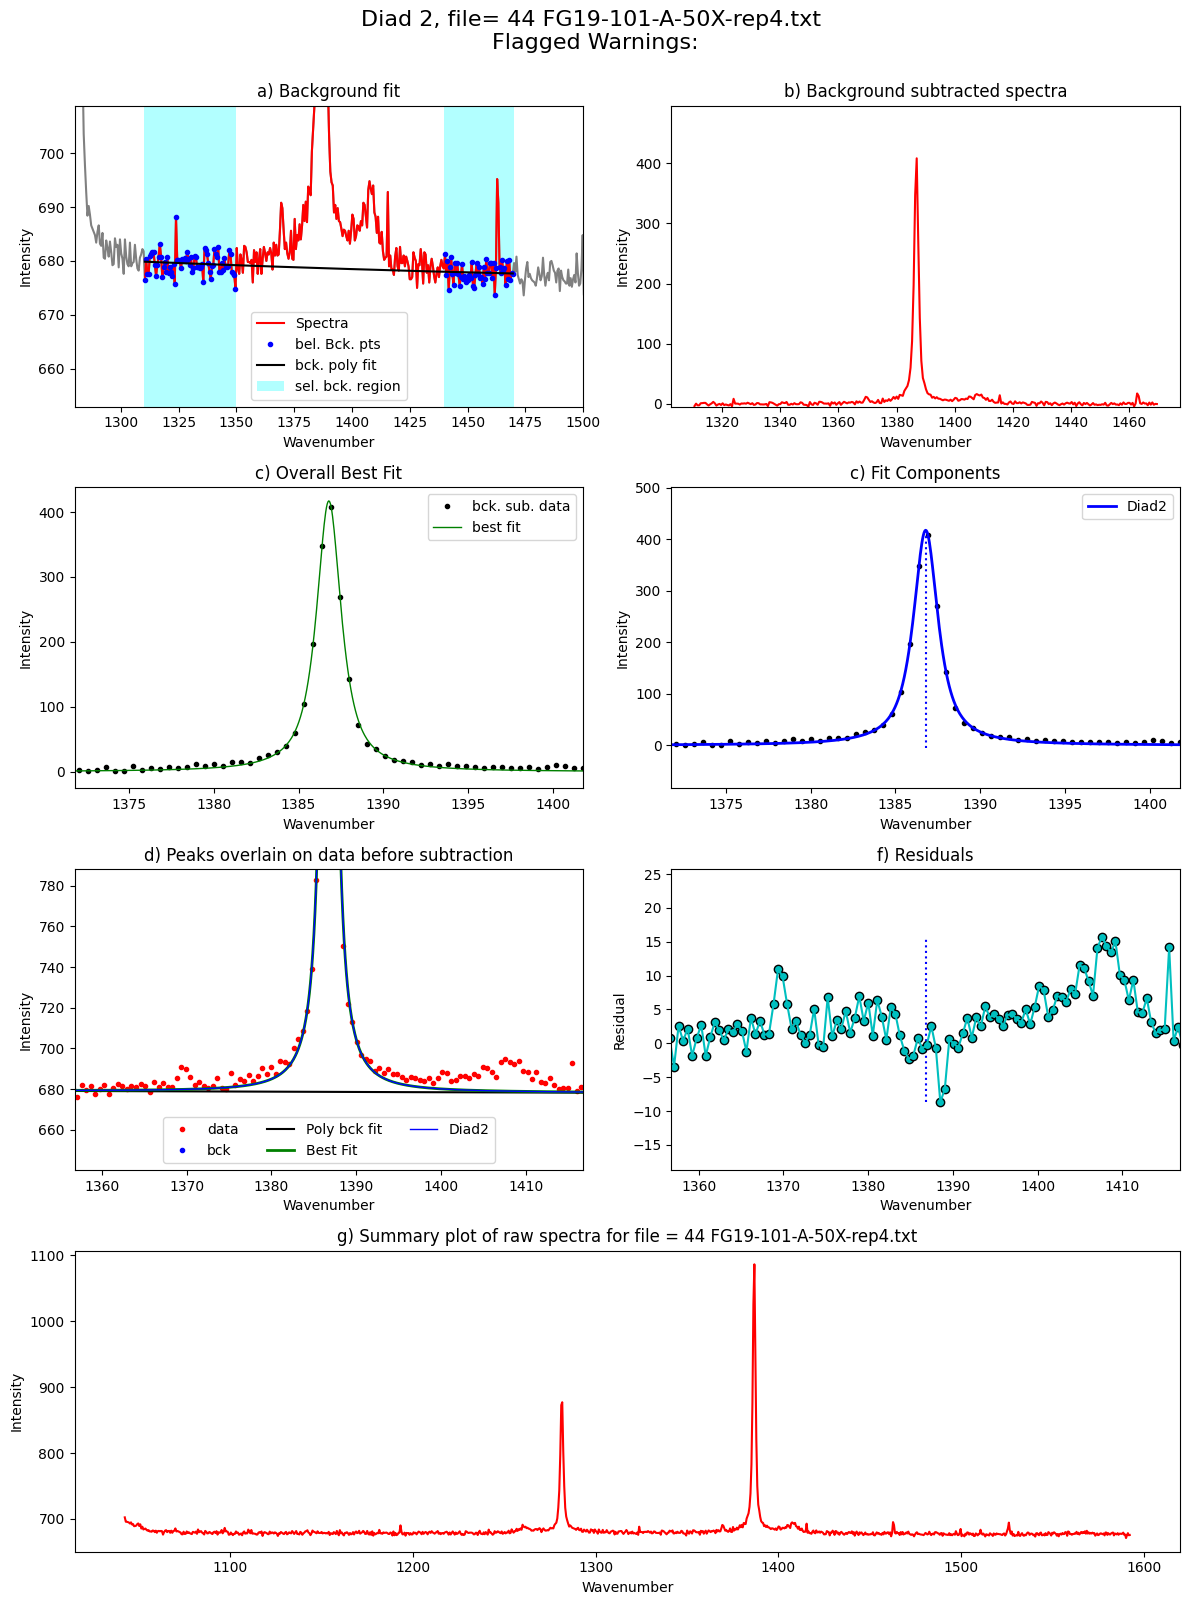

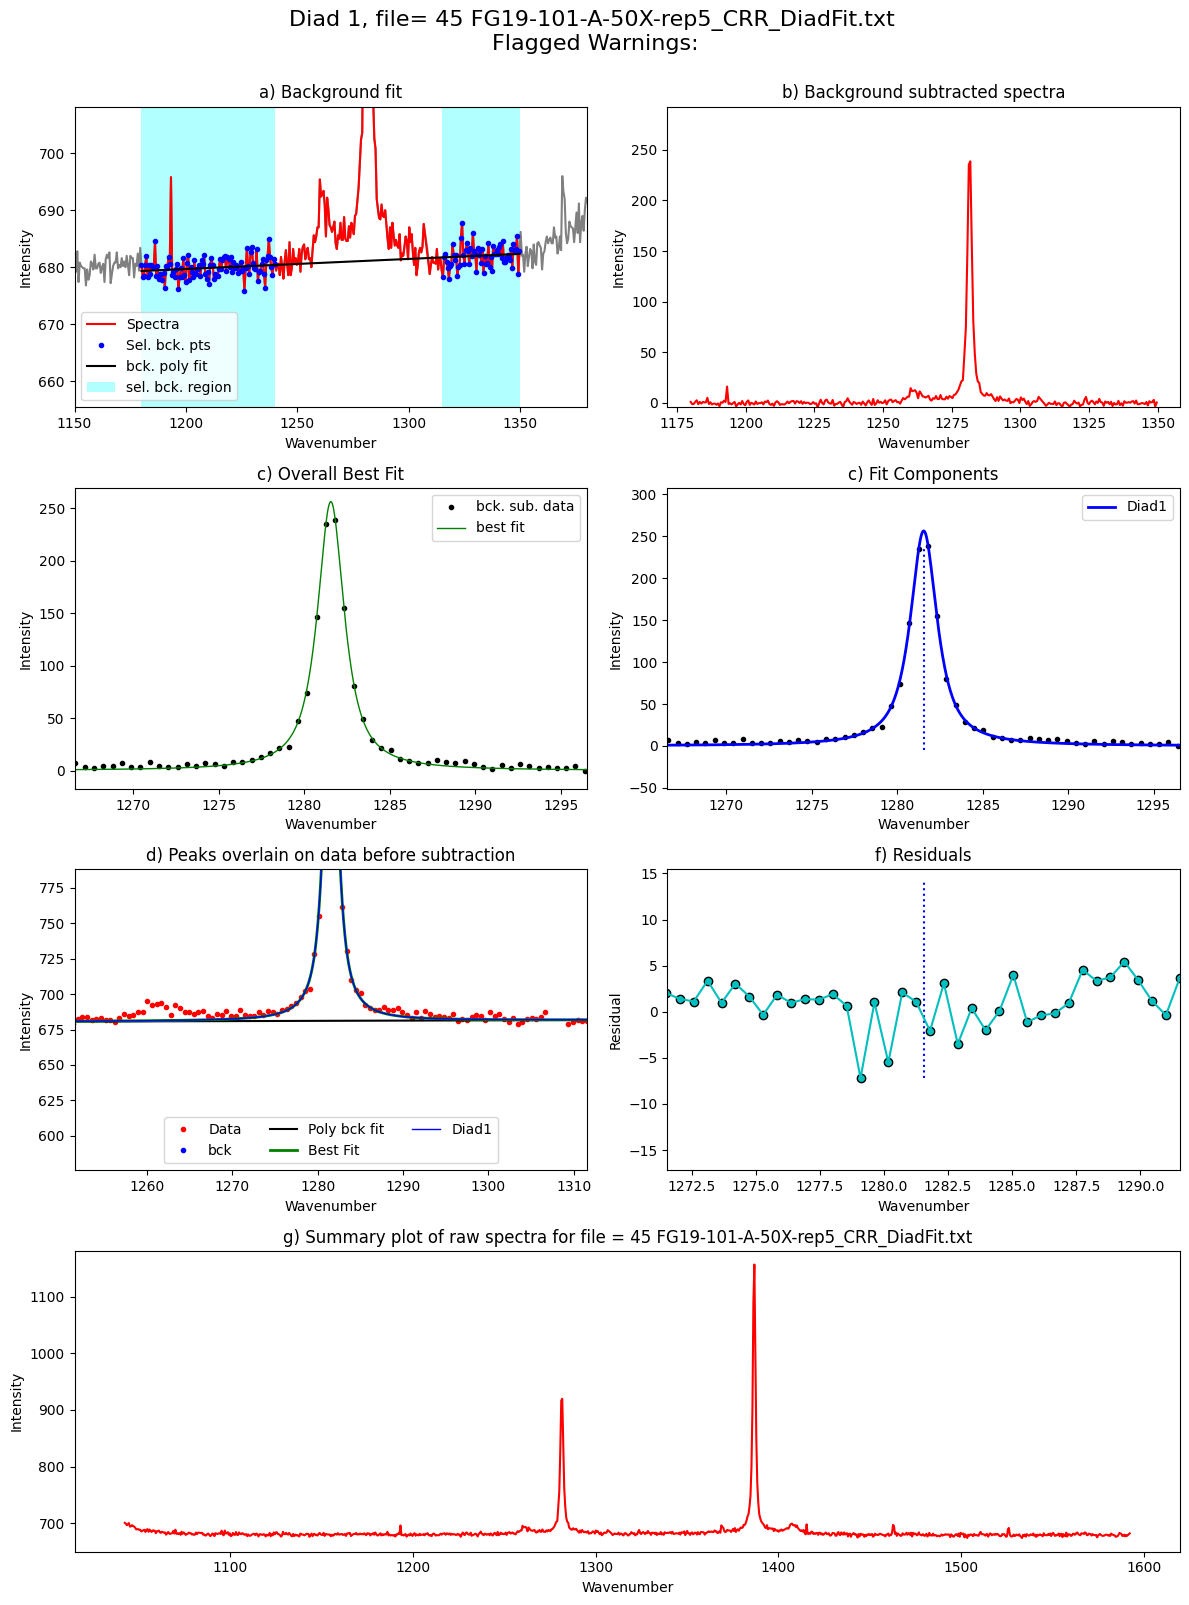

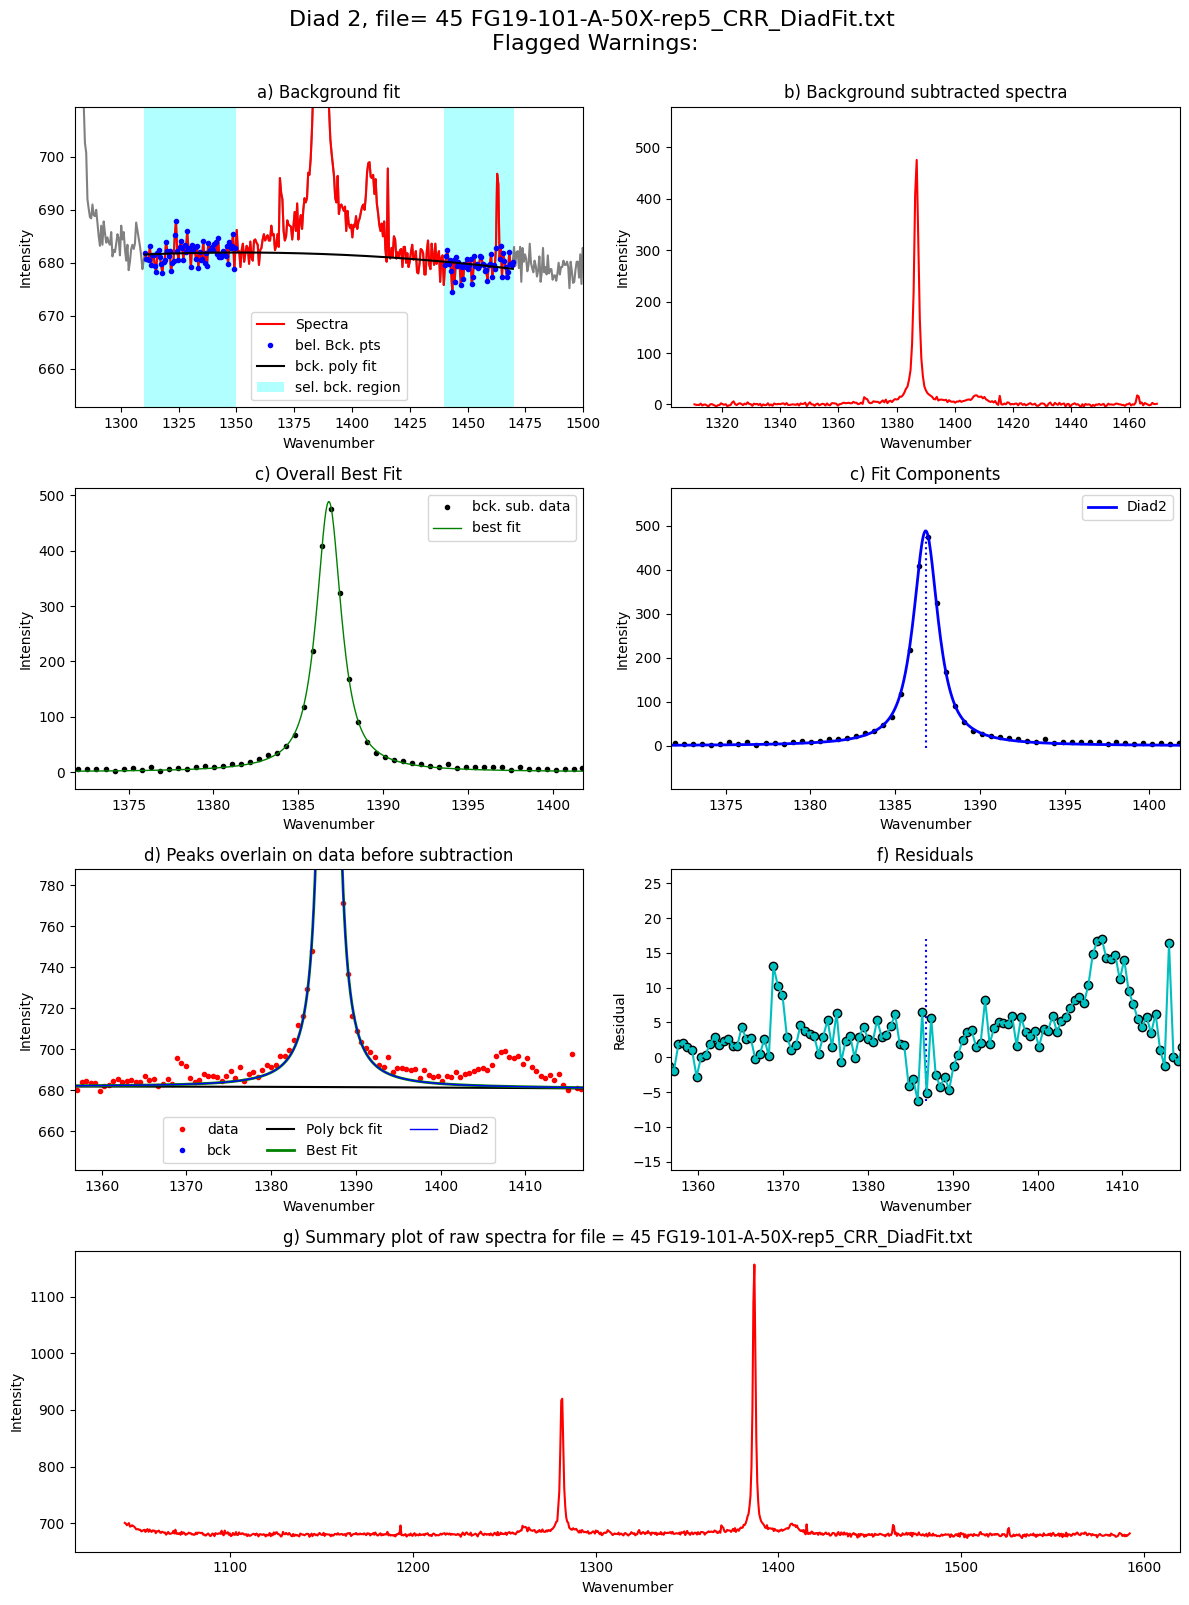

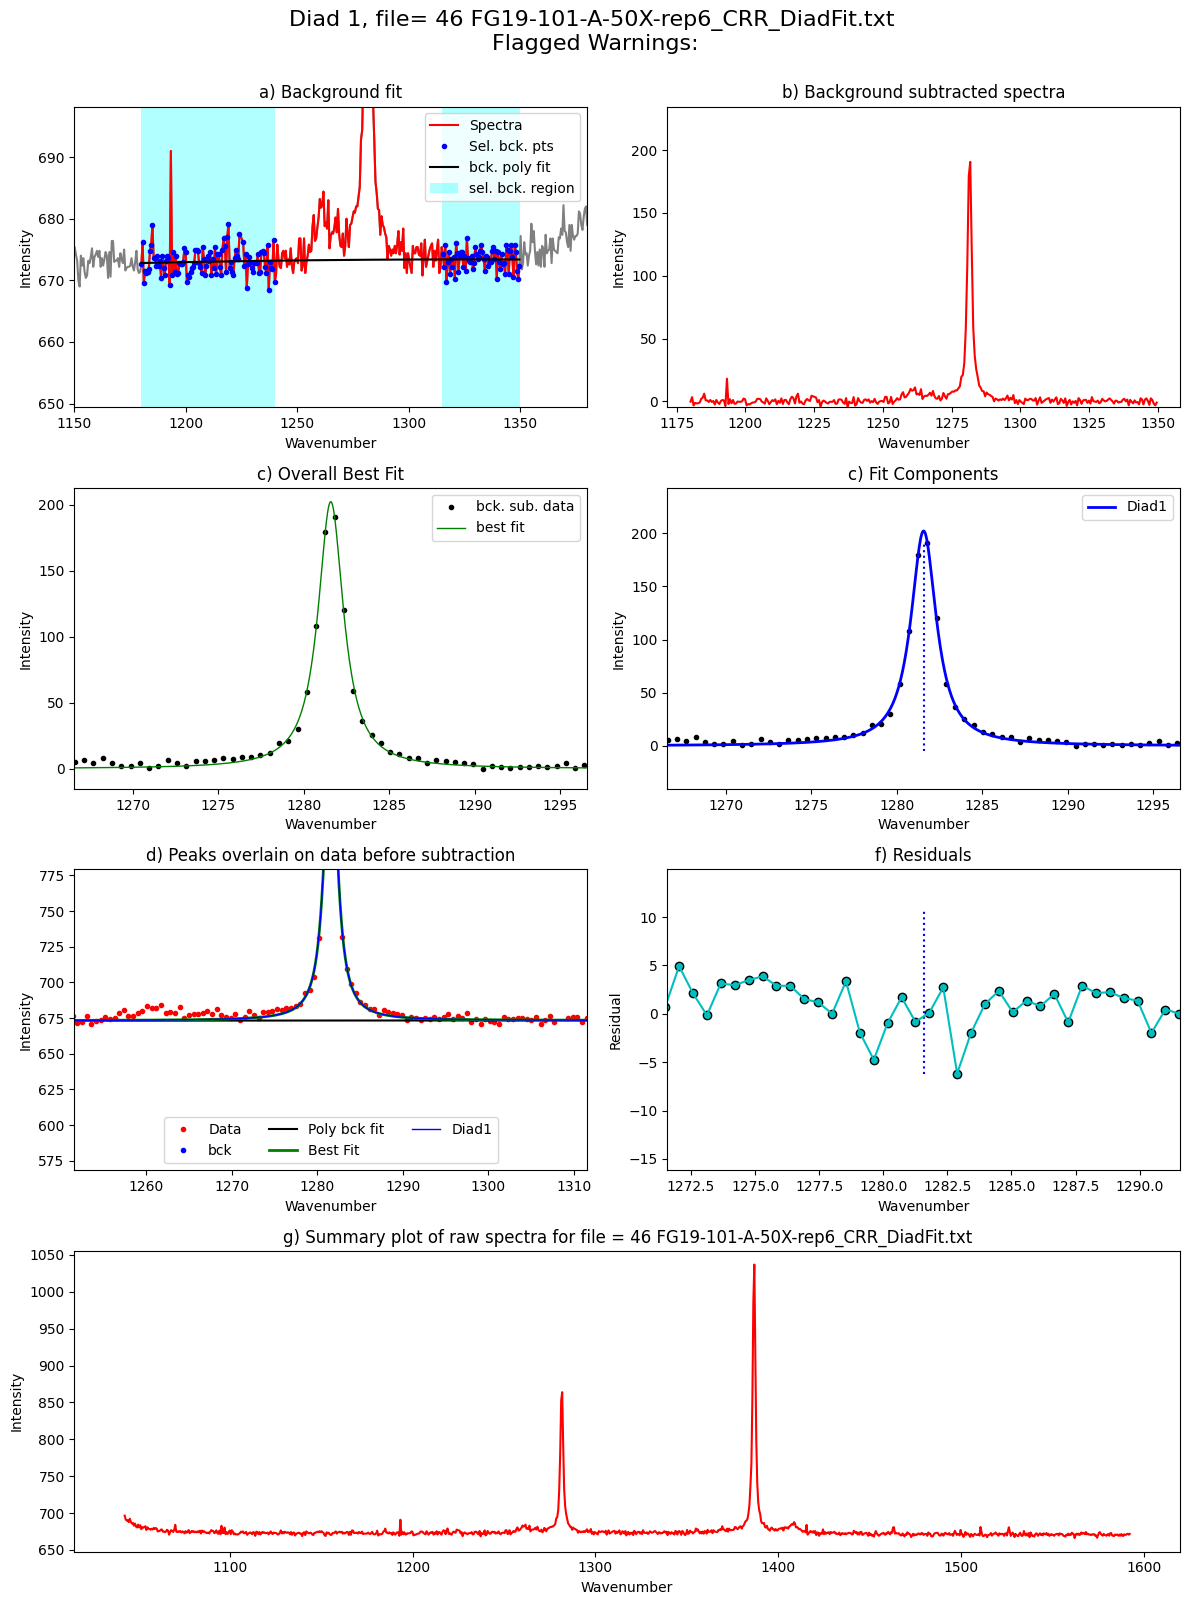

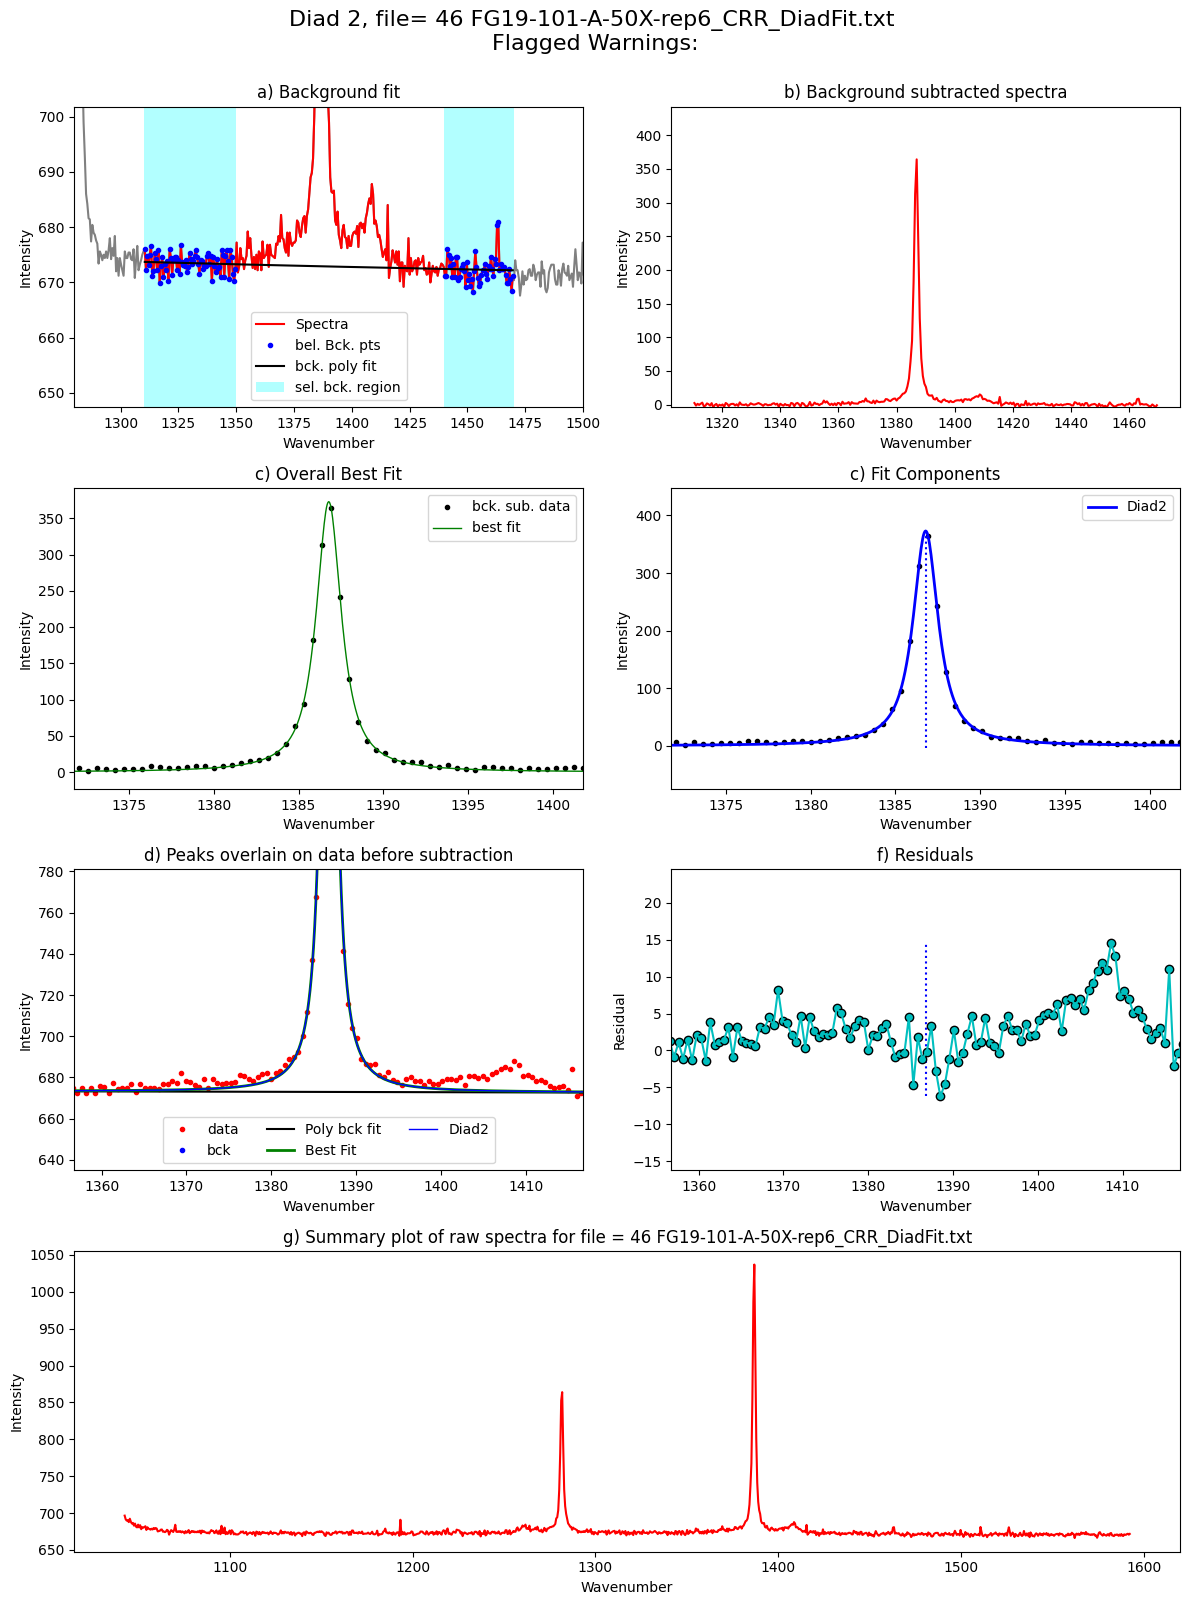

In [58]:
from tqdm import tqdm
plot_figure=True# If False, Means doesnt have to make figures, lot faster. 
close_figure=False # If True, wont show figures in notebook, but will still save them in a folder 
Diad_Files_i=Diad_Files
df_Merge = pd.DataFrame([])
for i in tqdm(range(0, len(Diad_Files))): #
    tqdm.write(f"Processing file: {Diad_Files[i]}")
    
    
    # For diad1, config file like you had in the previous. 
    # Only really used to exclude a range (say your spectra has a known spec)
    diad_id_config=pf.diad_id_config(exclude_range1=[1308, 1309])
    
    # Here, the prominence are taken from the fitting in the last notebook
    diad1_fit_config2.HB_prom=GroupN_df['HB1_abs_prom'].iloc[i]
    diad1_fit_config2.diad_prom=GroupN_df['Diad1_abs_prom'].iloc[i]
    diad1_fit_config2.gauss_amp=2*GroupN_df['HB1_abs_prom'].iloc[i]

    Diad1_fit=pf.fit_diad_1_w_bck(config1=diad1_fit_config2,
    config2=diad_id_config, path=spectra_path, filename=GroupN_df['filename'].iloc[i],
    filetype=spectra_filetype, plot_figure=plot_figure, close_figure=close_figure,
    Diad_pos=GroupN_df['Diad1_pos'].iloc[i],
    HB_pos=GroupN_df['HB1_pos'].iloc[i])

    ## Same for diad2, just also has a C13 peak
    diad2_fit_config_init.HB_prom=GroupN_df['HB2_abs_prom'].iloc[i]
    diad2_fit_config_init.diad_prom=GroupN_df['Diad2_abs_prom'].iloc[i]
    diad2_fit_config_init.gauss_amp= 2*GroupN_df['HB2_abs_prom'].iloc[i]
    diad2_fit_config_init.C13_prom=GroupN_df['C13_abs_prom'].iloc[i]
    
    
    Diad2_fit=pf.fit_diad_2_w_bck(config1=diad2_fit_config_init,
        config2=diad_id_config,
    path=spectra_path, filename=GroupN_df['filename'].iloc[i], 
    filetype=spectra_filetype,
    plot_figure=plot_figure, close_figure=close_figure,
    Diad_pos=GroupN_df['Diad2_pos'].iloc[i],
    HB_pos=GroupN_df['HB2_pos'].iloc[i], 
    C13_pos=GroupN_df['C13_pos'].iloc[i])
    
    # This combines the outputs into a single dataframe
    data=pf.combine_diad_outputs(filename=GroupN_df['filename'].iloc[i], prefix=prefix, 
    Diad1_fit=Diad1_fit, path=spectra_path,                  
    Diad2_fit=Diad2_fit)        
    
 

    df_Merge = pd.concat([df_Merge, data], axis=0).reset_index(drop=True)


In [59]:
# Save parameters to excel
combo=df_Merge

if batch=='Weak':
    combo.to_excel('Weak_Diads.xlsx', index=False)
if batch=='Medium':
    combo.to_excel('Medium_Diads.xlsx', index=False)
if batch=='Strong':
    combo.to_excel('Strong_Diads.xlsx', index=False)
if batch=='Std':
    combo.to_excel('Std_Diads.xlsx', index=False)

In [60]:
combo

filename   Splitting   Split_σ  Diad1_Combofit_Cent  \
0              FG19-101-A-50X-rep1  105.231430  0.011255          1281.592407   
1              FG19-101-A-50X-rep2  105.228898  0.010302          1281.600567   
2              FG19-101-A-50X-rep3  105.236463  0.011121          1281.590910   
3              FG19-101-A-50X-12mw  105.221192  0.009528          1281.602361   
4              FG19-101-A-50X-rep4  105.239559  0.012289          1281.550033   
5  FG19-101-A-50X-rep5_CRR_DiadFit  105.254531  0.011364          1281.550363   
6  FG19-101-A-50X-rep6_CRR_DiadFit  105.209499  0.012412          1281.572459   

   Diad1_cent_err  Diad1_Combofit_Height  Diad1_Voigt_Cent  Diad1_Voigt_Area  \
0        0.009239             240.596297       1281.592407        694.477796   
1        0.008266             236.025846       1281.600567        661.059097   
2        0.009643             253.129835       1281.590910        734.718576   
3        0.007560             436.839427       1281.602361       1248.859479   
4        0.009869             212.159051       1281.550033        614.449014   
5        0.009265             256.565667       1281.550363        736.291549   
6        0.010495             202.187673       1281.572459        569.026716   

   Diad1_Voigt_Sigma  Diad1_Residual  ...  Diad1_Asym50  Diad1_Asym70  \
0           0.955891        2.690709  ...      1.059675      1.010638   
1           0.901922        2.235455  ...      1.134122      1.023573   
2           0.960259        2.856421  ...      1.026224      1.032020   
3           0.937666        3.958674  ...      1.052920      1.009756   
4           0.937323        2.456115  ...      1.003571      1.018051   
5           0.945922        2.659976  ...      1.026643      1.030000   
6           0.903263        2.299891  ...      1.073724      1.106525   

  Diad1_Yuan2017_sym_factor  Diad1_Remigi2021_BSF  Diad2_Asym50  Diad2_Asym70  \
0                  0.114085              0.007946      1.022642      1.017016   
1                  0.241936              0.007643      1.066536      1.042216   
2                  0.050363              0.007587      1.053254      1.018568   
3                  0.099242              0.004293      1.032075      1.021823   
4                  0.006695              0.008836      1.072549      1.054521   
5                  0.050404              0.007374      1.007634      1.003942   
6                  0.133184              0.008935      1.093567      1.056878   

   Diad2_Yuan2017_sym_factor  Diad2_Remigi2021_BSF   Diad1_PDF_Model  \
0                   0.040300              0.003854  PseudoVoigtModel   
1                   0.117440              0.004029  PseudoVoigtModel   
2                   0.092349              0.003519  PseudoVoigtModel   
3                   0.057700              0.002185  PseudoVoigtModel   
4                   0.127652              0.004218  PseudoVoigtModel   
5                   0.013380              0.003585  PseudoVoigtModel   
6                   0.166855              0.004779  PseudoVoigtModel   

    Diad2_PDF_Model  
0  PseudoVoigtModel  
1  PseudoVoigtModel  
2  PseudoVoigtModel  
3  PseudoVoigtModel  
4  PseudoVoigtModel  
5  PseudoVoigtModel  
6  PseudoVoigtModel  

[7 rows x 49 columns]

### This plays a sound when the notebook is done if you have a tendency to procrastinate

In [61]:
# # !pip install winotify

# from winotify import Notification, audio

# toast= Notification(app_id="VSCode",title="Notebook completed",
#                     msg="Step3b_Secondary_Peaks is done!",
#                     duration="short")
# toast.set_audio(audio.Mail,loop=False)
# toast.show()